# Psych 253 Project
**Dawn Finzi 6/13/2018**

## Introduction and Methods

For this project, I wanted to begin investigating how/if object representations in human ventral temporal cortex (VTC) change across development. In pursuit of this, I analyzed a dataset we have been collecting within the Grill-Spector Laboratory which includes a number of fMRI, structural MRI and behavioral measurements across two cohorts: children (24 participants; ages 5 to 12) and adults (26 participants; ages 22 to 28). This study will ultimately be tracking development of visual cortex longitudinally, but for the purposes of this project I have limited analysis to our initial fMRI localizer experiment (one session) in each subject. 

In the experiment, participants were presented with grayscale images of stimuli from five domains, each with two categories (faces: child, adult; bodies: whole, limbs; places: corridors, houses; characters: pseudowords, numbers; objects: cars, guitars) as described previously (Stigliani et al., 2015). Images from each subcategory were presented in 4s mini-blocks at a rate of 2 Hz, intermixed with 4s blank mini-blocks. Each category was shown eight times in a run in counterbalanced order. Participants were instructed to fixate on a central point and perform an oddball detection task, identifying phase scrambled images within a block. Runs were 318s long and participants completed 3 runs. Data were collected with a simultaneous multi-slice EPI sequence with a multiplexing factor (Feinberg and Setsompop, 2013) of 3 to acquire near whole-brain (48 slices) volumes at TR = 1s, TE = 30 ms at a resolution of 2.4 mm isotropic. Data were acquired with a one-shot T2*-sensitive gradient echo sequence and slices were aligned parallel to the parieto-occipital sulcus. 

Data preprocessing was performed in MATLAB (www.mathworks.com) and using the mrVista analysis software (http://github.com/vistalab). I aligned the functional data to an artificial T1-weighted volume, generated from the participant's quantitative MRI measurements. All data analyzed within the individual participant native brain anatomy space without spatial smoothing. Data were motion corrected within and between scans, using mrVista motion correction algorithms. All participants included in the analyses in this notebook (both children and adults) moved less than 2 voxels within a scan. Functional data were restricted to the cortical ribbon by growing a 3-voxel thick ribbon from the gray-white matter boundary. 

I defined ventral temporal cortex individually as an anatomical region of interest (ROI) on each participant’s inflated cortical surface in each hemisphere as in previous publications (Weiner & Grill-Spector, 2010). VTC definition: anterior border: anterior tip of the mid fusiform sulcus (MFS) which aligned with the posterior end of the hippocampus; posterior border: posterior transverse collateral sulcus (ptCoS). I then calculated multi-voxel patterns for each ROI (left and right hemisphere) in each subject for all three runs by calculating response amplitudes estimated from the general linear model in each voxel for each category and transforming these values to z-scores. These are the values that we will be working with from this point on. All analyses will be performed separately for each hemisphere given the known right-lateralization of face processing and left-lateralization of language-related processes. 

### Importing data and general set-up

First, we will import the packages and code modules we will need for the project

In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

#the above imports the plotting library matplotlib

In [2]:
import time
import numpy as np
import scipy as sp
import scipy.stats as stats
import h5py

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
#loading code modules from class
import metrics 
import cross_validation as cv
from utils import featurewise_norm

In [4]:
#these are all the available subjects (alphabetically)
sessions = ('AD25', 'AG10', 'AI24', 'AS07', 'AM10', 'AK09', 'AS24',
           'AS10', 'BM24', 'CB24', 'CR24', 'CS22', 'DM06', 'EA23', 
           'EO08', 'GA11', 'IW06', 'JB11', 'JG24', 'JH22', 'JM25',
           'JP23', 'JW23', 'KG22', 'KW10', 'LB23', 'LL11', 'MA24', 
           'MB26', 'MC26', 'MC05', 'MT09', 'MC11', 'MH28', 'ML23', 
           'MW22', 'MW23', 'NC24', 'NV22', 'NW10', 'OS12', 'RA06', 
           'SA10', 'SG25', 'SM08', 'SM10', 'SO07', 'SS07', 'TL24', 'ZM05')

In [5]:
#let's set sessions based on age

#26 adults
adults = ('AD25', 'AI24', 'AS24', 'BM24', 'CB24', 'CR24', 
          'CS22', 'EA23', 'JG24', 'JH22', 'JM25','JP23', 
          'JW23', 'KG22', 'LB23', 'MA24', 'MB26', 'MC26', 
          'MH28', 'ML23', 'MW22', 'MW23', 'NC24', 'NV22',
          'SG25', 'TL24')

#24 kids
kids = ('AG10', 'AS07', 'AM10', 'AK09', 'AS10', 'DM06', 
           'EO08', 'GA11', 'IW06', 'JB11', 'KW10', 'LL11', 
           'MC05', 'MT09', 'MC11', 'NW10', 'OS12', 'RA06', 
           'SA10', 'SM08', 'SM10', 'SO07', 'SS07', 'ZM05')

#subdivide kids into younger and older children
#younger children - ages 5 to 9 (12 kids)
younger_kids = ('ZM05', 'MC05', 'RA06', 'DM06', 'IW06', 'AS07',
              'SS07', 'SO07', 'SM08', 'EO08', 'MT09', 'AK09')
older_kids = ('AG10', 'AM10', 'AS10', 'SA10', 'SM10', 'NW10',
              'KW10', 'GA11', 'JB11','MC11', 'LL11', 'OS12')

In [6]:
#meta data about the categories in our localizer experiment
labels = np.array(['faces_adults', 'faces_kids', 'bodies', 'limbs', 'cars', 
                   'guitars', 'corridors', 'houses', 'words', 'numbers'])
all_labels = np.hstack((labels,labels,labels)) #stacking for 3 runs for convenience
superord_labels = np.array(['faces', 'faces', 'bodies', 'bodies', 'objects', 
                   'objects', 'places', 'places', 'characters', 'characters'])
all_superord_labels = np.hstack((superord_labels,superord_labels,superord_labels)) #stacking for 3 runs for convenience

In [7]:
#Now we'll import the preprocessed fMRI data for all 3 runs for each subject (divided by hemisphere)

#left hemisphere VTC
#run 1
run1_lh = {}
for subj in sessions:
    stem = "_".join(['z1', subj, 'lh', 'vtc'])
    filename = ".".join([stem, 'mat'])
    f = h5py.File(filename,'r') 
    data = f.get('z_values1') 
    run1_lh[subj] = np.array(data) 
#run 2
run2_lh = {}
for subj in sessions:
    stem = "_".join(['z2', subj, 'lh', 'vtc'])
    filename = ".".join([stem, 'mat'])
    f = h5py.File(filename,'r') 
    data = f.get('z_values2') 
    run2_lh[subj] = np.array(data) 
#run 3  
run3_lh = {}
for subj in sessions:
    stem = "_".join(['z3', subj, 'lh', 'vtc'])
    filename = ".".join([stem, 'mat'])
    f = h5py.File(filename,'r') 
    data = f.get('z_values3') 
    run3_lh[subj] = np.array(data) 

#right hemisphere VTC
#run 1
run1_rh = {}
for subj in sessions:
    stem = "_".join(['z1', subj, 'rh', 'vtc'])
    filename = ".".join([stem, 'mat'])
    f = h5py.File(filename,'r') 
    data = f.get('z_values1') 
    run1_rh[subj] = np.array(data) 
#run 2
run2_rh = {}
for subj in sessions:
    stem = "_".join(['z2', subj, 'rh', 'vtc'])
    filename = ".".join([stem, 'mat'])
    f = h5py.File(filename,'r') 
    data = f.get('z_values2') 
    run2_rh[subj] = np.array(data) 
#run 3
run3_rh = {}
for subj in sessions:
    stem = "_".join(['z3', subj, 'rh', 'vtc'])
    filename = ".".join([stem, 'mat'])
    f = h5py.File(filename,'r') 
    data = f.get('z_values3') 
    run3_rh[subj] = np.array(data)   

Next, let's define some functions we will need

In [8]:
#specific get splits function that is appropriate for our data shape 

#since we extracted beta values for each category for each run, 
#that meant we only have 30 'stimuli' to work with (3 runs x 10 categories)

#this function returns 3 splits, each split uses 2 runs as training data and one run for testing

def get_splits(possible_data):
    
    num_splits=3;

    splits = []
    all_inds = np.arange(len(possible_data))

    for _split_ind in range(num_splits):

        actual_train_inds = []
        actual_test_inds = []
        if _split_ind == 1:
            actual_train_inds.extend(range(0,20))
            actual_test_inds.extend(range(20,30))
        elif _split_ind == 2:
            actual_train_inds.extend(range(10,30))
            actual_test_inds.extend(range(0,10))
        else:
            actual_train_inds.extend(range(0,10)); actual_train_inds.extend(range(20,30))
            actual_test_inds.extend(range(10,20))


        split = {'train': actual_train_inds, 'test': actual_test_inds}
        splits.append(split)
        
    return splits

In [9]:
from sklearn.model_selection import GridSearchCV

def train_and_test_scikit_classifier(features, 
                                     labels,
                                     splits,
                                     model_class,
                                     model_args=None,
                                     gridcv_params=None,                                     
                                     feature_norm=True,
                                     return_models=False
                                    ):
    """Routine for contructing, training and testing correlation classifier
       
       Arguments: 
           features: (K, M) feature array where K = number of stimuli and M = number of features
           labels: length-K vector of labels to be predicted
           splits: splits of data (constructed by calling the get_splits function)
           model_class: the actual live pythone object that is the classifier "class" object
           model_args: dictionary of arguments for instantiating the classifier class obejct
           gridcv_params: dictionary of params for applying gridSearch cross-validation to
           feature_norm: apply featurewise_norm
           return_models: return actual trained models for each split
           
       Returns:
           dictionary summary of training and testing results
    
    """
    train_confmats = []
    test_confmats = []
    
    if model_args is None:
        model_args = {}
    
    training_sidedata = []
    train_classes = cv.validate_splits(splits, labels)
    
    models = []
    
    for split in splits:

        #here we instantiate the general classifier, whatever it is    
        model = model_class(**model_args)
    
        if gridcv_params is not None:
            model = GridSearchCV(model, gridcv_params)

        train_inds = split['train']
        test_inds = split['test']
        train_features = features[train_inds]
        train_labels = labels[train_inds]
        test_features = features[test_inds]
        test_labels = labels[test_inds]

        if feature_norm:
            train_features, fmean, fvar = featurewise_norm(train_features)
            sidedata = {'fmean': fmean, 'fvar': fvar}
            training_sidedata.append(sidedata)
        
        model.fit(train_features, train_labels)
        classes_ = model.classes_
        assert set(model.classes_) == set(train_classes)
        sidedata['classes_'] = classes_
        
        train_predictions = model.predict(train_features)
        train_confmat = metrics.get_confusion_matrix(train_predictions, 
                                                     train_labels, 
                                                     train_classes)
        train_confmats.append(train_confmat)
                
        if feature_norm:
            test_features, _ignore, _ignore = featurewise_norm(test_features,
                                                               fmean=fmean,
                                                               fvar=fvar)
            
        test_predictions = model.predict(test_features)
        test_confmat = metrics.get_confusion_matrix(test_predictions, test_labels, train_classes)
        test_confmats.append(test_confmat)
        
        if return_models:
            models.append(model)
        
    train_confmats = np.array(train_confmats)
    train_results = metrics.evaluate_results(train_confmats, train_classes)
    test_confmats = np.array(test_confmats)
    test_results = metrics.evaluate_results(test_confmats, train_classes)
    results = {'train': train_results,
               'test': test_results,
               'training_sidedata': training_sidedata}
    if return_models:
            results['models'] = models
            
    return results, train_classes

In [10]:
def visualize_confmat(cmat, ucats, fig=None):
    cmat = cmat.astype(float) / cmat.sum(0)
    if fig is None:
        plt.matshow(cmat)
    else:
        fig.gca().matshow(cmat)
    for i in range(cmat.shape[0]):
        for j in range(cmat.shape[1]):
            plt.text(j-.1, i, '%.2f%%' % (cmat[i, j] * 100), color='w')
    M = len(ucats)
    plt.xticks(np.arange(M), ucats)
    plt.yticks(np.arange(M), ucats)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

## Results

### Classification

In order to explore how object and category representations in VTC develop, I decided to first look at classification accuracy across categories by age group. In this section, I implement and the evaluate performance of three different classifiers from scikit-learn: a minimum distance classifier, a linear support vector classifier and a k-nearest neighbors classifier. 

In [11]:
#let's import the possible classifiers from scikit
from sklearn.svm import LinearSVC
import minimum_distance_classifier as mdc
from sklearn.neighbors import KNeighborsClassifier

#### Minimum distance classifiers

In [12]:
#implementing the minimum distance classifier for the adult data
adult_accuracy_rh = []; adult_confmats_rh = []; 
adult_accuracy_lh = []; adult_confmats_lh = []; 
for subj in adults:
    possible_data_rh = np.vstack((run1_rh[subj], run2_rh[subj], run3_rh[subj]))
    possible_data_lh = np.vstack((run1_lh[subj], run2_lh[subj], run3_lh[subj]))
    
    results_mdc_rh, train_classes_rh = train_and_test_scikit_classifier(features=possible_data_rh, 
                                           labels=all_labels,
                                           splits=get_splits(possible_data_rh),
                                           model_class=mdc.MinimumDistanceClassifier
                                          )
    
    results_mdc_lh, train_classes_lh = train_and_test_scikit_classifier(features=possible_data_lh, 
                                           labels=all_labels,
                                           splits=get_splits(possible_data_lh),
                                           model_class=mdc.MinimumDistanceClassifier
                                          )

    subj_acc_rh = 100*results_mdc_rh['test']['mean_accuracy']
    adult_accuracy_rh.append(subj_acc_rh)
    subj_confmat_rh = results_mdc_rh['test']['confusion_matrices'].mean(axis=0)
    adult_confmats_rh.append(subj_confmat_rh)
    
    subj_acc_lh = 100*results_mdc_lh['test']['mean_accuracy']
    adult_accuracy_lh.append(subj_acc_lh)
    subj_confmat_lh = results_mdc_lh['test']['confusion_matrices'].mean(axis=0)
    adult_confmats_lh.append(subj_confmat_lh)

In [13]:
print(adult_accuracy_rh)

print(adult_accuracy_lh)

print('Minimum Distance (Correlation) Classifier performance for adults right hemisphere: %.2f%%' % (np.mean(adult_accuracy_rh)))
print('Minimum Distance (Correlation) Classifier performance for adults left hemisphere: %.2f%%' % (np.mean(adult_accuracy_lh)))

[59.999999999999986, 60.0, 46.666666666666664, 66.66666666666666, 60.0, 40.0, 56.666666666666664, 33.333333333333336, 60.0, 49.999999999999986, 53.333333333333336, 56.666666666666664, 46.666666666666664, 40.0, 33.333333333333336, 43.33333333333333, 56.666666666666664, 39.99999999999999, 63.33333333333334, 49.999999999999986, 50.0, 43.33333333333333, 56.666666666666664, 36.666666666666664, 43.33333333333334, 46.666666666666664]
[70.0, 60.0, 49.999999999999986, 56.666666666666664, 46.666666666666664, 53.333333333333336, 76.66666666666667, 43.33333333333333, 56.666666666666664, 50.0, 66.66666666666666, 59.999999999999986, 49.999999999999986, 49.999999999999986, 46.666666666666664, 53.333333333333336, 46.666666666666664, 50.0, 66.66666666666666, 46.666666666666664, 56.666666666666664, 53.333333333333336, 46.666666666666664, 40.0, 43.33333333333333, 59.999999999999986]
Minimum Distance (Correlation) Classifier performance for adults right hemisphere: 49.74%
Minimum Distance (Correlation) Cl

As you can see, classification accuracy at the category level for the adult sample is 49.7% in the right hemisphere and 53.8% in the left. As chance is 10%, this is fairly high.

Text(0.5,1.05,'Confusion matrix for adults (right hemisphere)')

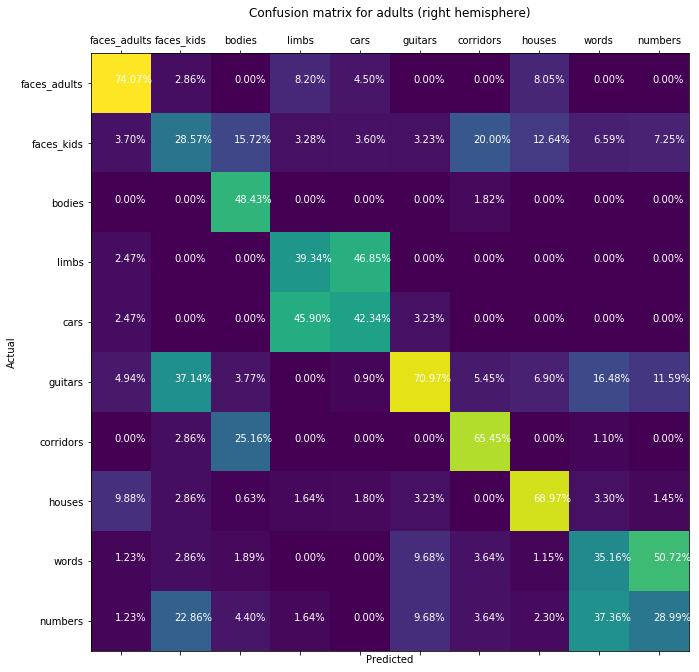

In [14]:
#we can also visualize the confusion matrix to learn more about how the categories are represented
adult_avg_confmat_rh = np.mean(adult_confmats_rh, axis=0)

fig = plt.figure(figsize=(11, 11))
visualize_confmat(adult_avg_confmat_rh, labels,fig)
plt.title("Confusion matrix for adults (right hemisphere)")

#words and numbers (both characters) appear to be frequently confused, which makes sense
#however, limbs and cars also appear to be often confused which I don't have a good explanation for
#I would have expected limbs and bodies to be confused and cars and guitars to be confused instead

Text(0.5,1.05,'Confusion matrix for adults (left hemisphere)')

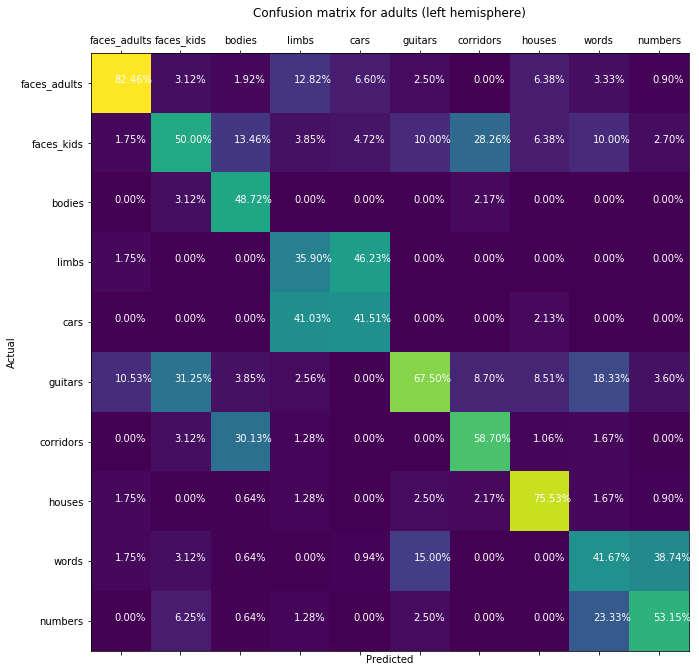

In [15]:
adult_avg_confmat_lh = np.mean(adult_confmats_lh, axis=0)

fig = plt.figure(figsize=(11, 11))
visualize_confmat(adult_avg_confmat_lh, labels,fig)
plt.title("Confusion matrix for adults (left hemisphere)")

#here we see a fairly similar pattern to the right hemisphere
#one possible difference is there appears to be less words/numbers condusion in left hemi?

In [16]:
#now let's implement the minimum distance classifier for the kid data
kids_accuracy_rh = []; kids_confmats_rh = []
kids_accuracy_lh = []; kids_confmats_lh = []
for subj in kids:
    possible_data_rh = np.vstack((run1_rh[subj], run2_rh[subj], run3_rh[subj]))
    possible_data_lh = np.vstack((run1_lh[subj], run2_lh[subj], run3_lh[subj]))
    
    results_mdc_rh, train_classes_rh = train_and_test_scikit_classifier(features=possible_data_rh, 
                                           labels=all_labels,
                                           splits=get_splits(possible_data_rh),
                                           model_class=mdc.MinimumDistanceClassifier
                                          )
    results_mdc_lh, train_classes_lh = train_and_test_scikit_classifier(features=possible_data_lh, 
                                           labels=all_labels,
                                           splits=get_splits(possible_data_lh),
                                           model_class=mdc.MinimumDistanceClassifier
                                          )
    
    subj_acc_rh = 100*results_mdc_rh['test']['mean_accuracy']
    kids_accuracy_rh.append(subj_acc_rh)   
    subj_confmat_rh = results_mdc_rh['test']['confusion_matrices'].mean(axis=0)
    kids_confmats_rh.append(subj_confmat_rh)
    
    subj_acc_lh = 100*results_mdc_lh['test']['mean_accuracy']
    kids_accuracy_lh.append(subj_acc_lh)   
    subj_confmat_lh = results_mdc_lh['test']['confusion_matrices'].mean(axis=0)
    kids_confmats_lh.append(subj_confmat_lh)

In [17]:
print(kids_accuracy_rh)

print(kids_accuracy_lh)

print('Minimum Distance (Correlation) Classifier performance for kids right hemisphere: %.2f%%' % (np.mean(kids_accuracy_rh)))
print('Minimum Distance (Correlation) Classifier performance for kids left hemisphere: %.2f%%' % (np.mean(kids_accuracy_lh)))

[63.33333333333333, 56.666666666666664, 43.33333333333333, 63.33333333333334, 56.66666666666668, 59.999999999999986, 13.333333333333334, 26.66666666666667, 66.66666666666666, 56.666666666666664, 46.666666666666664, 50.0, 66.66666666666666, 29.999999999999993, 43.33333333333334, 43.33333333333332, 43.33333333333333, 43.33333333333333, 53.333333333333336, 40.0, 43.33333333333333, 26.66666666666666, 40.0, 60.0]
[46.666666666666664, 46.66666666666668, 46.666666666666664, 36.66666666666667, 56.66666666666668, 66.66666666666666, 23.333333333333332, 50.0, 56.666666666666664, 66.66666666666666, 50.0, 60.0, 49.999999999999986, 20.0, 46.666666666666664, 50.0, 56.666666666666664, 56.666666666666664, 56.666666666666664, 40.0, 50.000000000000014, 33.333333333333336, 26.666666666666668, 70.00000000000001]
Minimum Distance (Correlation) Classifier performance for kids right hemisphere: 47.36%
Minimum Distance (Correlation) Classifier performance for kids left hemisphere: 48.47%


As with the adults we're seeing fairly high classification accuracy (47.4% for the right hemisphere and 48.5% for the left hemisphere).

Text(0.5,1.05,'Confusion matrix for kids (right hemisphere)')

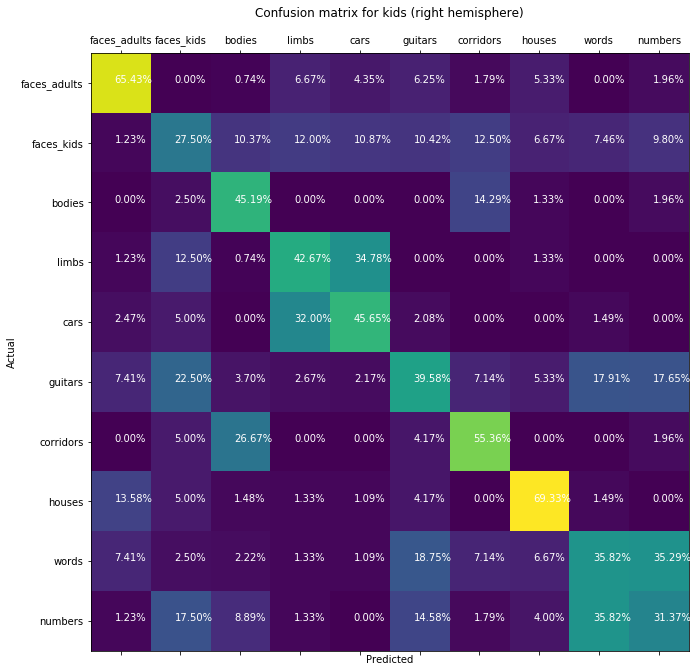

In [18]:
#let's look at the kids' confusion matrices
kids_avg_confmat_rh = np.mean(kids_confmats_rh, axis=0)

fig = plt.figure(figsize=(11, 11))
visualize_confmat(kids_avg_confmat_rh, labels,fig)
plt.title("Confusion matrix for kids (right hemisphere)")

Text(0.5,1.05,'Confusion matrix for kids (left hemisphere)')

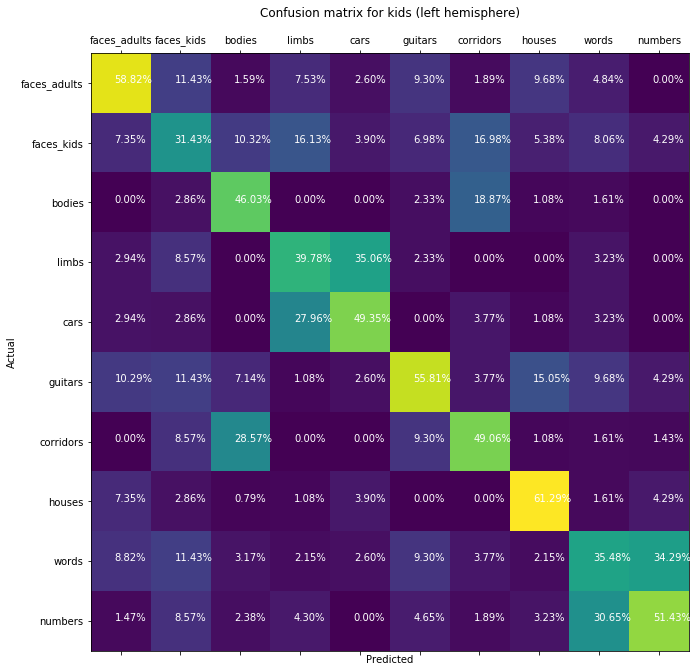

In [19]:
kids_avg_confmat_lh = np.mean(kids_confmats_lh, axis=0)

fig = plt.figure(figsize=(11, 11))
visualize_confmat(kids_avg_confmat_lh, labels,fig)
plt.title("Confusion matrix for kids (left hemisphere)")

Now we can ask if classification accuracy at the category level is significantly higher for the adults then the kids in either hemisphere. 

In [20]:
print(stats.ttest_ind(adult_accuracy_rh,kids_accuracy_rh))
print(stats.ttest_ind(adult_accuracy_lh,kids_accuracy_lh))

Ttest_indResult(statistic=0.7154818069069219, pvalue=0.4777774631230596)
Ttest_indResult(statistic=1.7022193587485293, pvalue=0.09518322005899885)


We see that classification accuracy at the category level is not significantly higher for adults than kids in either the right (*t*(48) = 0.72, *p* = .478) or left (*t*(48) = 1.70, *p* = .095) hemispheres. 

Now let's look instead at the superordinate (or domain) level. Our object catgeories (child faces, adult faces, bodies, limbs, corridors, houses, pseudowords, numbers, cars, and guitars) can be categorized by their superordinate category as well into 5 domains (faces, bodies, places, characters and objects). It's possible the child VTC can already categorize well at the specific sub-category level but that larger domains aren't as well delineated. We can test this by looking at domain classification across the two groups.

In [21]:
#looking at the superordinate level
#note that chance here is 20%
adult_accuracy_SO_rh = []; adult_confmats_SO_rh = [];
adult_accuracy_SO_lh = []; adult_confmats_SO_lh = [];
for subj in adults:
    possible_data_rh = np.vstack((run1_rh[subj], run2_rh[subj], run3_rh[subj]))
    possible_data_lh = np.vstack((run1_lh[subj], run2_lh[subj], run3_lh[subj]))
    
    results_mdc_rh, train_classes_rh = train_and_test_scikit_classifier(features=possible_data_rh, 
                                           labels=all_superord_labels,
                                           splits=get_splits(possible_data_rh),
                                           model_class=mdc.MinimumDistanceClassifier
                                          )
    results_mdc_lh, train_classes_lh = train_and_test_scikit_classifier(features=possible_data_lh, 
                                           labels=all_superord_labels,
                                           splits=get_splits(possible_data_lh),
                                           model_class=mdc.MinimumDistanceClassifier
                                          )
    
    subj_acc_rh = 100*results_mdc_rh['test']['mean_accuracy']
    adult_accuracy_SO_rh.append(subj_acc_rh)   
    subj_confmat_rh = results_mdc_rh['test']['confusion_matrices'].mean(axis=0)
    adult_confmats_SO_rh.append(subj_confmat_rh)
    
    subj_acc_lh = 100*results_mdc_lh['test']['mean_accuracy']
    adult_accuracy_SO_lh.append(subj_acc_lh)   
    subj_confmat_lh = results_mdc_lh['test']['confusion_matrices'].mean(axis=0)
    adult_confmats_SO_lh.append(subj_confmat_lh)

print('Correlation Classifier performance for adults 5-way right hemisphere: %.2f%%' % (np.mean(adult_accuracy_SO_rh)))
print('Correlation Classifier performance for adults 5-way left hemisphere: %.2f%%' % (np.mean(adult_accuracy_SO_lh)))

kids_accuracy_SO_rh = []; kids_confmats_SO_rh = [];
kids_accuracy_SO_lh = []; kids_confmats_SO_lh = [];
for subj in kids:
    possible_data_rh = np.vstack((run1_rh[subj], run2_rh[subj], run3_rh[subj]))
    possible_data_lh = np.vstack((run1_lh[subj], run2_lh[subj], run3_lh[subj]))
    
    results_mdc_rh, train_classes_rh = train_and_test_scikit_classifier(features=possible_data_rh, 
                                           labels=all_superord_labels,
                                           splits=get_splits(possible_data_rh),
                                           model_class=mdc.MinimumDistanceClassifier
                                          )
    results_mdc_lh, train_classes_lh = train_and_test_scikit_classifier(features=possible_data_lh, 
                                           labels=all_superord_labels,
                                           splits=get_splits(possible_data_lh),
                                           model_class=mdc.MinimumDistanceClassifier
                                          )
    
    subj_acc_rh = 100*results_mdc_rh['test']['mean_accuracy']
    kids_accuracy_SO_rh.append(subj_acc_rh)    
    subj_confmat_rh = results_mdc_rh['test']['confusion_matrices'].mean(axis=0)
    kids_confmats_SO_rh.append(subj_confmat_rh)
    
    subj_acc_lh = 100*results_mdc_lh['test']['mean_accuracy']
    kids_accuracy_SO_lh.append(subj_acc_lh)    
    subj_confmat_lh = results_mdc_lh['test']['confusion_matrices'].mean(axis=0)
    kids_confmats_SO_lh.append(subj_confmat_lh)

print('Correlation Classifier performance for kids 5-way right hemisphere: %.2f%%' % (np.mean(kids_accuracy_SO_rh)))
print('Correlation Classifier performance for kids 5-way left hemisphere: %.2f%%' % (np.mean(kids_accuracy_SO_lh)))

Correlation Classifier performance for adults 5-way right hemisphere: 78.97%
Correlation Classifier performance for adults 5-way left hemisphere: 81.28%
Correlation Classifier performance for kids 5-way right hemisphere: 72.64%
Correlation Classifier performance for kids 5-way left hemisphere: 73.61%


In [22]:
print(stats.ttest_ind(adult_accuracy_SO_rh,kids_accuracy_SO_rh))
print(stats.ttest_ind(adult_accuracy_SO_lh,kids_accuracy_SO_lh))
#okay so what actually seems to be changing is domain classification

Ttest_indResult(statistic=3.125678371390013, pvalue=0.003008899147342114)
Ttest_indResult(statistic=3.119589869912966, pvalue=0.003060949555906274)


Here, we see that domain classification accuracy actually is different between adults and kids, with adults showing significantly higher classification accuracy in both the right (*t*(48) = 3.13, *p* = .003) and left (*t*(48) = 3.12, *p* = .003) hemispheres.

Text(0.5,1.05,'Confusion matrix at the superordinate level for adults (right hemisphere)')

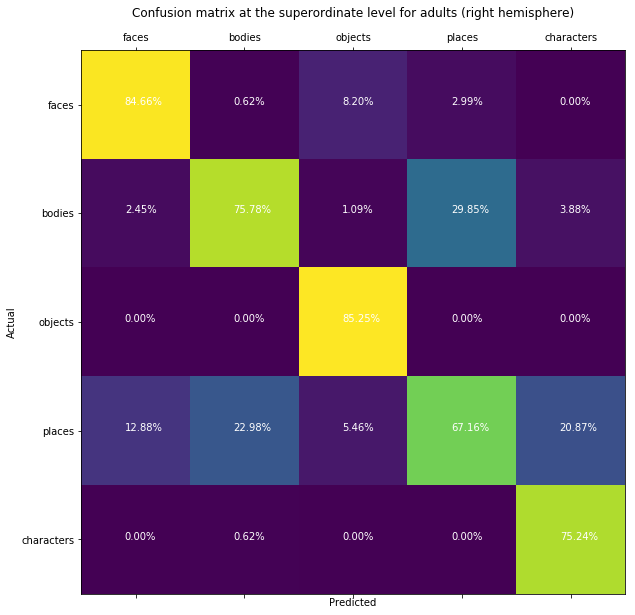

In [23]:
#let's look at the confusion matrices for the superordinate level
SO_labels = np.array(['faces', 'bodies', 'objects', 
                   'places','characters'])

adult_SO_avg_confmat_rh = np.mean(adult_confmats_SO_rh, axis=0)

fig = plt.figure(figsize=(10,10))
visualize_confmat(adult_SO_avg_confmat_rh, SO_labels,fig)
plt.title("Confusion matrix at the superordinate level for adults (right hemisphere)")

Text(0.5,1.05,'Confusion matrix at the superordinate level for adults (left hemisphere)')

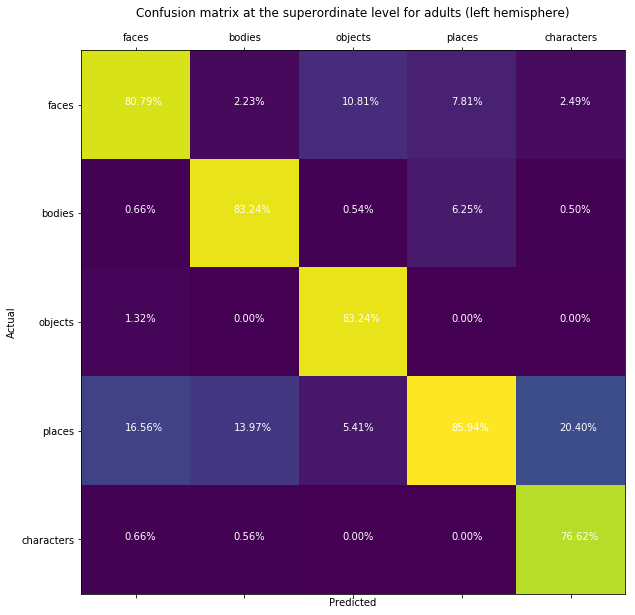

In [24]:
adult_SO_avg_confmat_lh = np.mean(adult_confmats_SO_lh, axis=0)

fig = plt.figure(figsize=(10,10))
visualize_confmat(adult_SO_avg_confmat_lh, SO_labels,fig)
plt.title("Confusion matrix at the superordinate level for adults (left hemisphere)")

Text(0.5,1.05,'Confusion matrix at the superordinate level for kids (right hemisphere)')

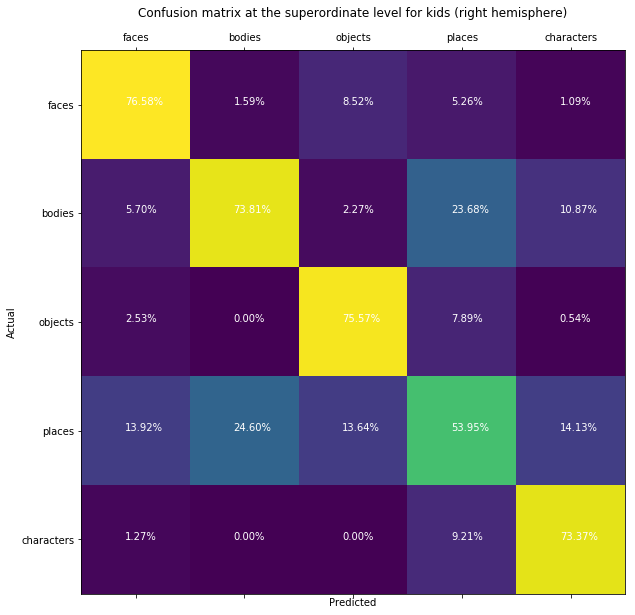

In [25]:
kids_SO_avg_confmat_rh = np.mean(kids_confmats_SO_rh, axis=0)

fig = plt.figure(figsize=(10,10))
visualize_confmat(kids_SO_avg_confmat_rh, SO_labels,fig)
plt.title("Confusion matrix at the superordinate level for kids (right hemisphere)")

Text(0.5,1.05,'Confusion matrix at the superordinate level for kids (left hemisphere)')

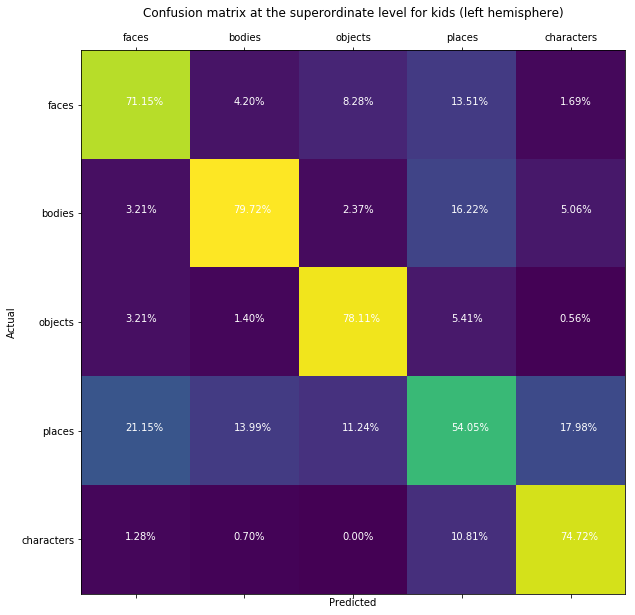

In [26]:
kids_SO_avg_confmat_lh = np.mean(kids_confmats_SO_lh, axis=0)

fig = plt.figure(figsize=(10,10))
visualize_confmat(kids_SO_avg_confmat_lh, SO_labels,fig)
plt.title("Confusion matrix at the superordinate level for kids (left hemisphere)")

#### Linear SVCs

In [27]:
#okay now let's compare Linear SVMs

#categorization for adults (subcategory level)

adult_accuracy_SVC_rh = []; adult_confmats_SVC_rh = [];
adult_accuracy_SVC_lh = []; adult_confmats_SVC_lh = [];
for subj in adults:
    possible_data_rh = np.vstack((run1_rh[subj], run2_rh[subj], run3_rh[subj]))
    possible_data_lh = np.vstack((run1_lh[subj], run2_lh[subj], run3_lh[subj]))
    
    results_rh, train_classes_rh = train_and_test_scikit_classifier(features=possible_data_rh, 
                                           labels=all_labels,
                                           splits=get_splits(possible_data_rh),
                                           model_class=LinearSVC)
    results_lh, train_classes_lh = train_and_test_scikit_classifier(features=possible_data_lh, 
                                           labels=all_labels,
                                           splits=get_splits(possible_data_lh),
                                           model_class=LinearSVC)
    
    subj_acc_rh = 100*results_rh['test']['mean_accuracy']
    adult_accuracy_SVC_rh.append(subj_acc_rh)
    subj_confmat_rh = results_rh['test']['confusion_matrices'].mean(axis=0)
    adult_confmats_SVC_rh.append(subj_confmat_rh)
    
    subj_acc_lh = 100*results_lh['test']['mean_accuracy']
    adult_accuracy_SVC_lh.append(subj_acc_lh)
    subj_confmat_lh = results_lh['test']['confusion_matrices'].mean(axis=0)
    adult_confmats_SVC_lh.append(subj_confmat_lh)
    
kids_accuracy_SVC_rh = []; kids_confmats_SVC_rh = [];
kids_accuracy_SVC_lh = []; kids_confmats_SVC_lh = [];
for subj in kids:
    possible_data_rh = np.vstack((run1_rh[subj], run2_rh[subj], run3_rh[subj]))
    possible_data_lh = np.vstack((run1_lh[subj], run2_lh[subj], run3_lh[subj]))
    
    results_rh, train_classes_rh = train_and_test_scikit_classifier(features=possible_data_rh, 
                                           labels=all_labels,
                                           splits=get_splits(possible_data_rh),
                                           model_class=LinearSVC)
    results_lh, train_classes_lh = train_and_test_scikit_classifier(features=possible_data_lh, 
                                           labels=all_labels,
                                           splits=get_splits(possible_data_lh),
                                           model_class=LinearSVC)
  
    subj_acc_rh = 100*results_rh['test']['mean_accuracy']
    kids_accuracy_SVC_rh.append(subj_acc_rh)   
    subj_confmat_rh = results_rh['test']['confusion_matrices'].mean(axis=0)
    kids_confmats_SVC_rh.append(subj_confmat_rh)
    
    subj_acc_lh = 100*results_lh['test']['mean_accuracy']
    kids_accuracy_SVC_lh.append(subj_acc_lh)   
    subj_confmat_lh = results_lh['test']['confusion_matrices'].mean(axis=0)
    kids_confmats_SVC_lh.append(subj_confmat_lh)
    
    
print('SVC Classifier performance for adults 10-way right hemisphere: %.2f%%' % (np.mean(adult_accuracy_SVC_rh)))
print('SVC Classifier performance for adults 10-way left hemisphere: %.2f%%' % (np.mean(adult_accuracy_SVC_lh)))

print('SVC Classifier performance for kids 10-way right hemisphere: %.2f%%' % (np.mean(kids_accuracy_SVC_rh)))
print('SVC Classifier performance for kids 10-way left hemisphere: %.2f%%' % (np.mean(kids_accuracy_SVC_lh)))


SVC Classifier performance for adults 10-way right hemisphere: 48.72%
SVC Classifier performance for adults 10-way left hemisphere: 54.10%
SVC Classifier performance for kids 10-way right hemisphere: 47.22%
SVC Classifier performance for kids 10-way left hemisphere: 50.56%


In [28]:
#let's make sure we get the same results 
#(i.e. that subcategory classification accuracy is not significantly different across the two groups)
print(stats.ttest_ind(adult_accuracy_SVC_rh,kids_accuracy_SVC_rh))
print(stats.ttest_ind(adult_accuracy_SVC_lh,kids_accuracy_SVC_lh))
#yup

Ttest_indResult(statistic=0.4818522996696594, pvalue=0.6321006839993395)
Ttest_indResult(statistic=1.155583858276124, pvalue=0.2535713138376394)


In [29]:
#let's directly compare the two classifiers we've implemented so far
print('SVC Classifier performance for adults 10-way right hemisphere: %.2f%%' % (np.mean(adult_accuracy_SVC_rh)))
print('Correlation Classifier performance for adults 10-way right hemisphere: %.2f%%' % (np.mean(adult_accuracy_rh)))

print('SVC Classifier performance for adults 10-way left hemisphere: %.2f%%' % (np.mean(adult_accuracy_SVC_lh)))
print('Correlation Classifier performance for adults 10-way left hemisphere: %.2f%%' % (np.mean(adult_accuracy_lh)))

print('SVC Classifier performance for kids 10-way right hemisphere: %.2f%%' % (np.mean(kids_accuracy_SVC_rh)))
print('Correlation Classifier performance for kids 10-way right hemisphere: %.2f%%' % (np.mean(kids_accuracy_rh)))

print('SVC Classifier performance for kids 10-way left hemisphere: %.2f%%' % (np.mean(kids_accuracy_SVC_lh)))
print('Correlation Classifier performance for kids 10-way left hemisphere: %.2f%%' % (np.mean(kids_accuracy_lh)))

#interesting - SVC performs slightly worse in the right hemi but better in the left

SVC Classifier performance for adults 10-way right hemisphere: 48.72%
Correlation Classifier performance for adults 10-way right hemisphere: 49.74%
SVC Classifier performance for adults 10-way left hemisphere: 54.10%
Correlation Classifier performance for adults 10-way left hemisphere: 53.85%
SVC Classifier performance for kids 10-way right hemisphere: 47.22%
Correlation Classifier performance for kids 10-way right hemisphere: 47.36%
SVC Classifier performance for kids 10-way left hemisphere: 50.56%
Correlation Classifier performance for kids 10-way left hemisphere: 48.47%


In [30]:
#okay well what about at the superordinate level?
adult_accuracy_SO_SVC_rh = []; adult_confmats_SO_SVC_rh = [];
adult_accuracy_SO_SVC_lh = []; adult_confmats_SO_SVC_lh = [];
for subj in adults:
    possible_data_rh = np.vstack((run1_rh[subj], run2_rh[subj], run3_rh[subj]))
    possible_data_lh = np.vstack((run1_lh[subj], run2_lh[subj], run3_lh[subj]))
    
    results_rh, train_classes_rh = train_and_test_scikit_classifier(features=possible_data_rh, 
                                           labels=all_superord_labels,
                                           splits=get_splits(possible_data_rh),
                                           model_class=LinearSVC
                                          )
    results_lh, train_classes_lh = train_and_test_scikit_classifier(features=possible_data_lh, 
                                           labels=all_superord_labels,
                                           splits=get_splits(possible_data_lh),
                                           model_class=LinearSVC
                                          )
    
    subj_acc_rh = 100*results_rh['test']['mean_accuracy']
    adult_accuracy_SO_SVC_rh.append(subj_acc_rh)    
    subj_confmat_rh = results_rh['test']['confusion_matrices'].mean(axis=0)
    adult_confmats_SO_SVC_rh.append(subj_confmat_rh)
    
    subj_acc_lh = 100*results_lh['test']['mean_accuracy']
    adult_accuracy_SO_SVC_lh.append(subj_acc_lh)    
    subj_confmat_lh = results_lh['test']['confusion_matrices'].mean(axis=0)
    adult_confmats_SO_SVC_lh.append(subj_confmat_lh)

print('SVC performance for adults 5-way right hemisphere: %.2f%%' % (np.mean(adult_accuracy_SO_SVC_rh)))
print('SVC performance for adults 5-way left hemisphere: %.2f%%' % (np.mean(adult_accuracy_SO_SVC_lh)))

kids_accuracy_SO_SVC_rh = []; kids_confmats_SO_SVC_rh = [];
kids_accuracy_SO_SVC_lh = []; kids_confmats_SO_SVC_lh = [];
for subj in kids:
    possible_data_rh = np.vstack((run1_rh[subj], run2_rh[subj], run3_rh[subj]))
    possible_data_lh = np.vstack((run1_lh[subj], run2_lh[subj], run3_lh[subj]))
    
    results_rh, train_classes_rh = train_and_test_scikit_classifier(features=possible_data_rh, 
                                           labels=all_superord_labels,
                                           splits=get_splits(possible_data_rh),
                                           model_class=LinearSVC
                                          )
    results_lh, train_classes_lh = train_and_test_scikit_classifier(features=possible_data_lh, 
                                           labels=all_superord_labels,
                                           splits=get_splits(possible_data_lh),
                                           model_class=LinearSVC
                                          )
    
    subj_acc_rh = 100*results_rh['test']['mean_accuracy']
    kids_accuracy_SO_SVC_rh.append(subj_acc_rh)  
    subj_confmat_rh = results_rh['test']['confusion_matrices'].mean(axis=0)
    kids_confmats_SO_SVC_rh.append(subj_confmat_rh)
    
    subj_acc_lh = 100*results_lh['test']['mean_accuracy']
    kids_accuracy_SO_SVC_lh.append(subj_acc_lh)  
    subj_confmat_lh = results_lh['test']['confusion_matrices'].mean(axis=0)
    kids_confmats_SO_SVC_lh.append(subj_confmat_lh)

print('SVC performance for kids 5-way right hemisphere: %.2f%%' % (np.mean(kids_accuracy_SO_SVC_rh)))
print('SVC performance for kids 5-way left hemisphere: %.2f%%' % (np.mean(kids_accuracy_SO_SVC_lh)))


print('CC performance for adults 5-way right hemisphere: %.2f%%' % (np.mean(adult_accuracy_SO_rh)))
print('CC performance for adults 5-way left hemisphere: %.2f%%' % (np.mean(adult_accuracy_SO_lh)))
print('CC performance for kids 5-way right hemisphere: %.2f%%' % (np.mean(kids_accuracy_SO_rh)))
print('CC performance for kids 5-way left hemisphere: %.2f%%' % (np.mean(kids_accuracy_SO_lh)))

#okay but here it's slightly better than the correlation classifier for both hemispheres and age groups
#let's work with SVM classifier going forward

SVC performance for adults 5-way right hemisphere: 83.85%
SVC performance for adults 5-way left hemisphere: 84.23%
SVC performance for kids 5-way right hemisphere: 76.25%
SVC performance for kids 5-way left hemisphere: 75.97%
CC performance for adults 5-way right hemisphere: 78.97%
CC performance for adults 5-way left hemisphere: 81.28%
CC performance for kids 5-way right hemisphere: 72.64%
CC performance for kids 5-way left hemisphere: 73.61%


In [31]:
#again, let's make sure we get the same results 
#(i.e. that domain classification accuracy IS significantly different across the two groups)
print(stats.ttest_ind(adult_accuracy_SO_SVC_rh,kids_accuracy_SO_SVC_rh))
print(stats.ttest_ind(adult_accuracy_SO_SVC_lh,kids_accuracy_SO_SVC_lh))
#okay great

Ttest_indResult(statistic=3.5134547314174327, pvalue=0.0009752664244051723)
Ttest_indResult(statistic=3.5182013869699262, pvalue=0.000961527943352068)


Here, we see that as with the minimum distance correlation classifier, domain classification accuracy actually is different between adults and kids, with adults showing significantly higher classification accuracy in both the right (*t*(48) = 3.51, *p* < .001) and left (*t*(48) = 3.52, *p* < .001) hemispheres.

In [32]:
#Would we see differences if we further subdivided the kids into two groups (6-9 years and 10-12 years)
#Here is classification for young kids vs old kids

younger_kids_accuracy_SVC_rh = []; younger_kids_confmats_SVC_rh = []
younger_kids_accuracy_SVC_lh = []; younger_kids_confmats_SVC_lh = []
for subj in younger_kids:
    possible_data_rh = np.vstack((run1_rh[subj], run2_rh[subj], run3_rh[subj]))
    possible_data_lh = np.vstack((run1_lh[subj], run2_lh[subj], run3_lh[subj]))
    
    results_rh, train_classes_rh = train_and_test_scikit_classifier(features=possible_data_rh, 
                                           labels=all_labels,
                                           splits=get_splits(possible_data_rh),
                                           model_class=LinearSVC
                                          )
    results_lh, train_classes_lh = train_and_test_scikit_classifier(features=possible_data_lh, 
                                           labels=all_labels,
                                           splits=get_splits(possible_data_lh),
                                           model_class=LinearSVC
                                          )
    
    subj_acc_rh = 100*results_rh['test']['mean_accuracy']
    younger_kids_accuracy_SVC_rh.append(subj_acc_rh)   
    subj_confmat_rh = results_rh['test']['confusion_matrices'].mean(axis=0)
    younger_kids_confmats_SVC_rh.append(subj_confmat_rh)
    
    subj_acc_lh = 100*results_lh['test']['mean_accuracy']
    younger_kids_accuracy_SVC_lh.append(subj_acc_lh)   
    subj_confmat_lh = results_lh['test']['confusion_matrices'].mean(axis=0)
    younger_kids_confmats_SVC_lh.append(subj_confmat_lh)

print('SVC performance for younger kids 10-way right hemisphere: %.2f%%' % (np.mean(younger_kids_accuracy_SVC_rh)))
print('SVC performance for younger kids 10-way left hemisphere: %.2f%%' % (np.mean(younger_kids_accuracy_SVC_lh)))

older_kids_accuracy_SVC_rh = []; older_kids_confmats_SVC_rh = []
older_kids_accuracy_SVC_lh = []; older_kids_confmats_SVC_lh = []
for subj in older_kids:
    possible_data_rh = np.vstack((run1_rh[subj], run2_rh[subj], run3_rh[subj]))
    possible_data_lh = np.vstack((run1_lh[subj], run2_lh[subj], run3_lh[subj]))
    
    results_rh, train_classes_rh = train_and_test_scikit_classifier(features=possible_data_rh, 
                                           labels=all_labels,
                                           splits=get_splits(possible_data_rh),
                                           model_class=LinearSVC
                                          )
    results_lh, train_classes_lh = train_and_test_scikit_classifier(features=possible_data_lh, 
                                           labels=all_labels,
                                           splits=get_splits(possible_data_lh),
                                           model_class=LinearSVC
                                          )
    
    subj_acc_rh = 100*results_rh['test']['mean_accuracy']
    older_kids_accuracy_SVC_rh.append(subj_acc_rh)   
    subj_confmat_rh = results_rh['test']['confusion_matrices'].mean(axis=0)
    older_kids_confmats_SVC_rh.append(subj_confmat_rh)
    
    subj_acc_lh = 100*results_lh['test']['mean_accuracy']
    older_kids_accuracy_SVC_lh.append(subj_acc_lh)   
    subj_confmat_lh = results_lh['test']['confusion_matrices'].mean(axis=0)
    older_kids_confmats_SVC_lh.append(subj_confmat_lh)

print('SVC performance for older kids 10-way right hemisphere: %.2f%%' % (np.mean(older_kids_accuracy_SVC_rh)))
print('SVC performance for older kids 10-way left hemisphere: %.2f%%' % (np.mean(older_kids_accuracy_SVC_lh)))


SVC performance for younger kids 10-way right hemisphere: 45.56%
SVC performance for younger kids 10-way left hemisphere: 47.50%
SVC performance for older kids 10-way right hemisphere: 48.89%
SVC performance for older kids 10-way left hemisphere: 53.61%


In [33]:
#young kids vs old kids - superordinate categories

younger_kids_accuracy_SO_SVC_rh = []; younger_kids_confmats_SO_SVC_rh = []
younger_kids_accuracy_SO_SVC_lh = []; younger_kids_confmats_SO_SVC_lh = []
for subj in younger_kids:
    possible_data_rh = np.vstack((run1_rh[subj], run2_rh[subj], run3_rh[subj]))
    possible_data_lh = np.vstack((run1_lh[subj], run2_lh[subj], run3_lh[subj]))
    
    results_rh, train_classes_rh = train_and_test_scikit_classifier(features=possible_data_rh, 
                                           labels=all_superord_labels,
                                           splits=get_splits(possible_data_rh),
                                           model_class=LinearSVC
                                          )
    results_lh, train_classes_lh = train_and_test_scikit_classifier(features=possible_data_lh, 
                                           labels=all_superord_labels,
                                           splits=get_splits(possible_data_lh),
                                           model_class=LinearSVC
                                          )
    
    subj_acc_rh = 100*results_rh['test']['mean_accuracy']
    younger_kids_accuracy_SO_SVC_rh.append(subj_acc_rh)   
    subj_confmat_rh = results_rh['test']['confusion_matrices'].mean(axis=0)
    younger_kids_confmats_SO_SVC_rh.append(subj_confmat_rh)
    
    subj_acc_lh = 100*results_lh['test']['mean_accuracy']
    younger_kids_accuracy_SO_SVC_lh.append(subj_acc_lh)   
    subj_confmat_lh = results_lh['test']['confusion_matrices'].mean(axis=0)
    younger_kids_confmats_SO_SVC_lh.append(subj_confmat_lh)

print('SVC performance for younger kids 5-way right hemisphere: %.2f%%' % (np.mean(younger_kids_accuracy_SO_SVC_rh)))
print('SVC performance for younger kids 5-way left hemisphere: %.2f%%' % (np.mean(younger_kids_accuracy_SO_SVC_lh)))

older_kids_accuracy_SO_SVC_rh = []; older_kids_confmats_SO_SVC_rh = []
older_kids_accuracy_SO_SVC_lh = []; older_kids_confmats_SO_SVC_lh = []
for subj in older_kids:
    possible_data_rh = np.vstack((run1_rh[subj], run2_rh[subj], run3_rh[subj]))
    possible_data_lh = np.vstack((run1_lh[subj], run2_lh[subj], run3_lh[subj]))
    
    results_rh, train_classes_rh = train_and_test_scikit_classifier(features=possible_data_rh, 
                                           labels=all_superord_labels,
                                           splits=get_splits(possible_data_rh),
                                           model_class=LinearSVC
                                          )
    results_lh, train_classes_lh = train_and_test_scikit_classifier(features=possible_data_lh, 
                                           labels=all_superord_labels,
                                           splits=get_splits(possible_data_lh),
                                           model_class=LinearSVC
                                          )
    
    subj_acc_rh = 100*results_rh['test']['mean_accuracy']
    older_kids_accuracy_SO_SVC_rh.append(subj_acc_rh)   
    subj_confmat_rh = results_rh['test']['confusion_matrices'].mean(axis=0)
    older_kids_confmats_SO_SVC_rh.append(subj_confmat_rh)
    
    subj_acc_lh = 100*results_lh['test']['mean_accuracy']
    older_kids_accuracy_SO_SVC_lh.append(subj_acc_lh)   
    subj_confmat_lh = results_lh['test']['confusion_matrices'].mean(axis=0)
    older_kids_confmats_SO_SVC_lh.append(subj_confmat_lh)

print('SVC performance for older kids 5-way right hemisphere: %.2f%%' % (np.mean(older_kids_accuracy_SO_SVC_rh)))
print('SVC performance for older kids 5-way left hemisphere: %.2f%%' % (np.mean(older_kids_accuracy_SO_SVC_lh)))


SVC performance for younger kids 5-way right hemisphere: 74.17%
SVC performance for younger kids 5-way left hemisphere: 73.61%
SVC performance for older kids 5-way right hemisphere: 78.33%
SVC performance for older kids 5-way left hemisphere: 78.33%


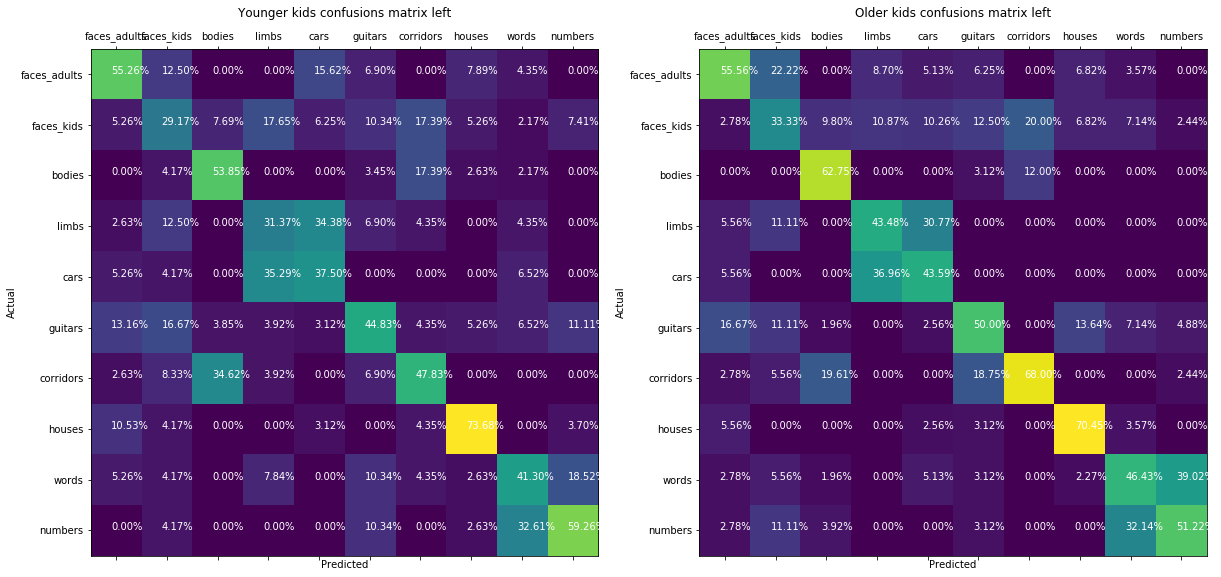

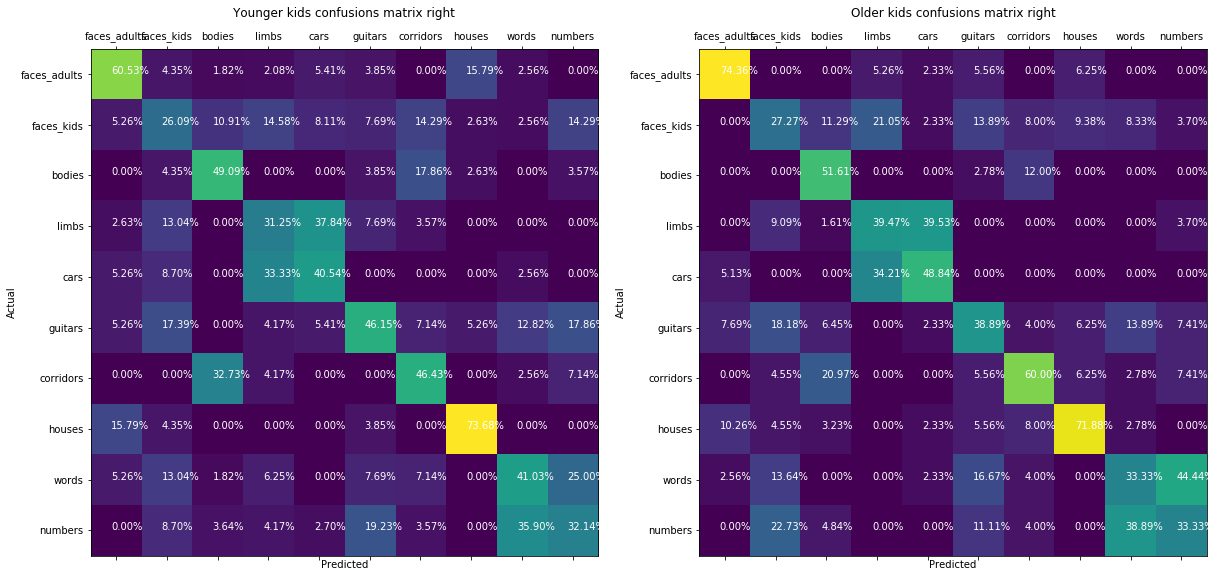

In [34]:
#let's look at the confusion matrices - maybe there are differences 
#(especially because older kids are more likely to know how to read)

younger_kids_avg_confmat_lh = np.mean(younger_kids_confmats_SVC_lh, axis=0)
older_kids_avg_confmat_lh = np.mean(older_kids_confmats_SVC_lh, axis=0)

fig = plt.figure(figsize=(20,20))
plt.subplot(1, 2, 1)
plt.title('Younger kids confusions matrix left')
visualize_confmat(younger_kids_avg_confmat_lh, labels,fig)
plt.subplot(1, 2, 2)
plt.title('Older kids confusions matrix left')
visualize_confmat(older_kids_avg_confmat_lh, labels,fig)

younger_kids_avg_confmat_rh = np.mean(younger_kids_confmats_SVC_rh, axis=0)
older_kids_avg_confmat_rh = np.mean(older_kids_confmats_SVC_rh, axis=0)

fig = plt.figure(figsize=(20,20))
plt.subplot(1, 2, 1)
plt.title('Younger kids confusions matrix right')
visualize_confmat(younger_kids_avg_confmat_rh, labels,fig)
plt.subplot(1, 2, 2)
plt.title('Older kids confusions matrix right')
visualize_confmat(older_kids_avg_confmat_rh, labels,fig)

Text(0.5,1.05,'Differences between old and young kids (right hemisphere)')

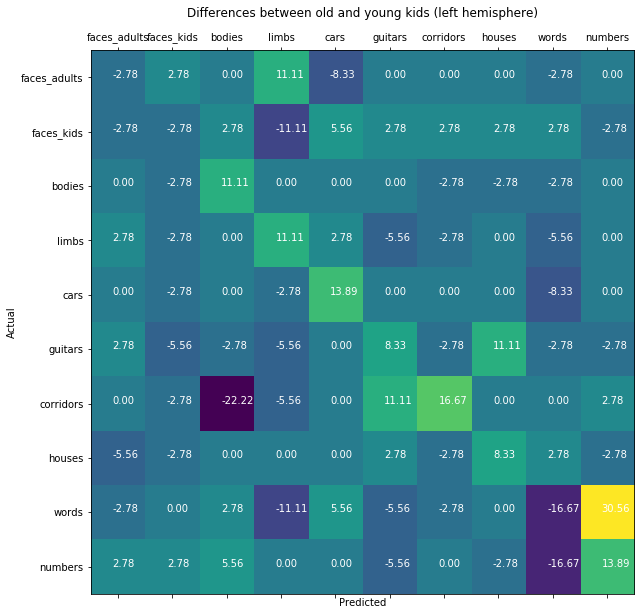

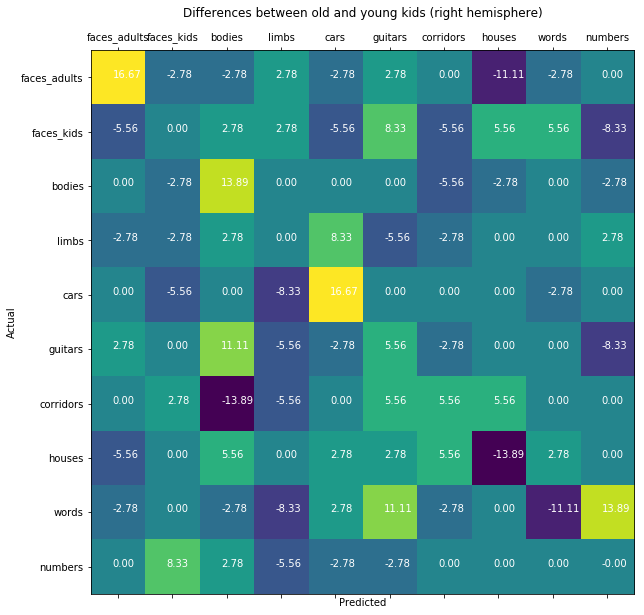

In [35]:
#maybe let's try visualizing just the differences

#left hemisphere
diff_confmat_lh = older_kids_avg_confmat_lh - younger_kids_avg_confmat_lh
fig = plt.figure(figsize=(10,10))
cmat = diff_confmat_lh; ucats = labels;

fig.gca().matshow(cmat)
for i in range(cmat.shape[0]):
    for j in range(cmat.shape[1]):
        plt.text(j-.1, i, '%.2f' % (cmat[i, j]*100), color='w')
M = len(ucats)
plt.xticks(np.arange(M), ucats)
plt.yticks(np.arange(M), ucats)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Differences between old and young kids (left hemisphere)')

#right hemisphere
diff_confmat_rh = older_kids_avg_confmat_rh - younger_kids_avg_confmat_rh
fig = plt.figure(figsize=(10,10))
cmat = diff_confmat_rh;

fig.gca().matshow(cmat)
for i in range(cmat.shape[0]):
    for j in range(cmat.shape[1]):
        plt.text(j-.1, i, '%.2f' % (cmat[i, j]*100), color='w')
M = len(ucats)
plt.xticks(np.arange(M), ucats)
plt.yticks(np.arange(M), ucats)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Differences between old and young kids (right hemisphere)')

Looks like there may be differences in face categorization in the right hemisphere and differences in character categorization in the left hemisphere between the two kid age groups?

#### K-nearest neighbors classifier

In [36]:
#let's try one last classification method
adult_accuracy_KNN = []
adult_confmats_KNN = []
for subj in adults:
    possible_data = np.vstack((run1_rh[subj], run2_rh[subj], run3_rh[subj]))
    
    results, train_classes = train_and_test_scikit_classifier(features=possible_data, 
                                           labels=all_labels,
                                           splits=get_splits(possible_data),
                                           model_class=KNeighborsClassifier,
                                              model_args={'n_neighbors': 5})
    
    subj_acc = 100*results['test']['mean_accuracy']
    adult_accuracy_KNN.append(subj_acc)
    
    subj_confmat = results['test']['confusion_matrices'].mean(axis=0)
    adult_confmats_KNN.append(subj_confmat)
    
print('KNN performance for adults 10-way: %.2f%%' % (np.mean(adult_accuracy_KNN)))
#eh

KNN performance for adults 10-way: 34.74%


### RSMs

Now let's take a look at the representational similarity matrices (RSMs) to probe differences in category representations more closely

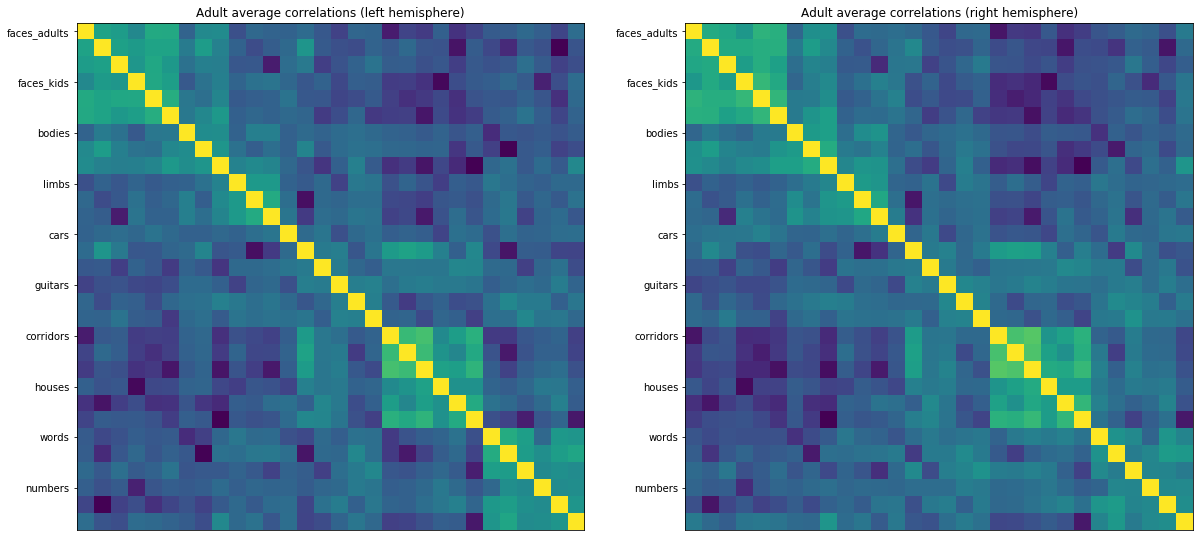

In [37]:
#let's create RSMs

all_corr_data_adult_rh = []; all_corr_data_adult_lh = [];
for subj in adults:
    
    #reorder so that we can see info from all 3 runs by category
    faces_adults = np.vstack((run1_rh[subj][0], run2_rh[subj][0], run3_rh[subj][0]))
    faces_kids = np.vstack((run1_rh[subj][1], run2_rh[subj][1], run3_rh[subj][1]))
    bodies = np.vstack((run1_rh[subj][2], run2_rh[subj][2], run3_rh[subj][2]))
    limbs = np.vstack((run1_rh[subj][3], run2_rh[subj][3], run3_rh[subj][3]))
    cars = np.vstack((run1_rh[subj][4], run2_rh[subj][4], run3_rh[subj][4]))
    guitars = np.vstack((run1_rh[subj][5], run2_rh[subj][5], run3_rh[subj][5]))
    corridors = np.vstack((run1_rh[subj][6], run2_rh[subj][6], run3_rh[subj][6]))
    houses = np.vstack((run1_rh[subj][7], run2_rh[subj][7], run3_rh[subj][7]))
    words = np.vstack((run1_rh[subj][8], run2_rh[subj][8], run3_rh[subj][8]))
    numbers = np.vstack((run1_rh[subj][9], run2_rh[subj][9], run3_rh[subj][9]))
    
    subj_data_rh = np.vstack((faces_adults, faces_kids, bodies, limbs, cars, 
                   guitars, corridors, houses, words, numbers))
    
    subj_corr_rh = np.corrcoef(subj_data_rh)
    all_corr_data_adult_rh.append(subj_corr_rh)
    
    #reorder so that we can see info from all 3 runs by category
    faces_adults = np.vstack((run1_lh[subj][0], run2_lh[subj][0], run3_lh[subj][0]))
    faces_kids = np.vstack((run1_lh[subj][1], run2_lh[subj][1], run3_lh[subj][1]))
    bodies = np.vstack((run1_lh[subj][2], run2_lh[subj][2], run3_lh[subj][2]))
    limbs = np.vstack((run1_lh[subj][3], run2_lh[subj][3], run3_lh[subj][3]))
    cars = np.vstack((run1_lh[subj][4], run2_lh[subj][4], run3_lh[subj][4]))
    guitars = np.vstack((run1_lh[subj][5], run2_lh[subj][5], run3_lh[subj][5]))
    corridors = np.vstack((run1_lh[subj][6], run2_lh[subj][6], run3_lh[subj][6]))
    houses = np.vstack((run1_lh[subj][7], run2_lh[subj][7], run3_lh[subj][7]))
    words = np.vstack((run1_lh[subj][8], run2_lh[subj][8], run3_lh[subj][8]))
    numbers = np.vstack((run1_lh[subj][9], run2_lh[subj][9], run3_lh[subj][9]))
    
    subj_data_lh = np.vstack((faces_adults, faces_kids, bodies, limbs, cars, 
                   guitars, corridors, houses, words, numbers))
    
    subj_corr_lh = np.corrcoef(subj_data_lh)
    all_corr_data_adult_lh.append(subj_corr_lh)



plt.figure(figsize=(20, 10))

adult_avg_corr_lh = np.mean(all_corr_data_adult_lh,axis=0)
plt.subplot(1, 2, 1)
plt.title('Adult average correlations (left hemisphere)')
plt.imshow(adult_avg_corr_lh)
plt.yticks(np.arange(0, 30, 3), labels); plt.xticks([]);

adult_avg_corr_rh = np.mean(all_corr_data_adult_rh,axis=0)
plt.subplot(1, 2, 2)
plt.title('Adult average correlations (right hemisphere)')
plt.imshow(adult_avg_corr_rh)
plt.yticks(np.arange(0, 30, 3), labels); plt.xticks([]);


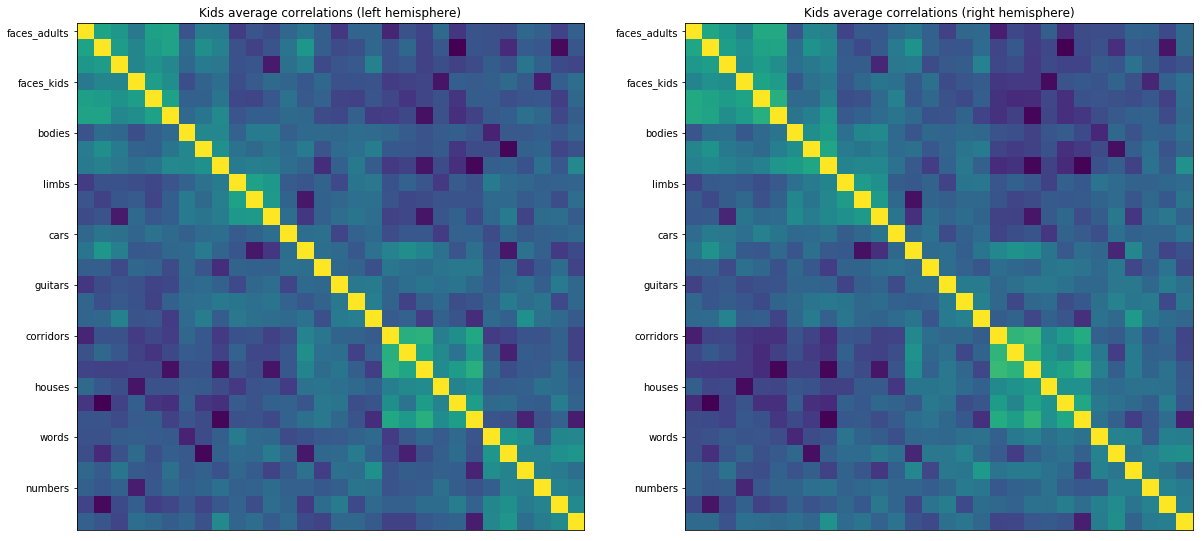

In [38]:
#kids RSMs

all_corr_data_kids_rh = []; all_corr_data_kids_lh = []
for subj in kids:
    
    #reorder so that we can see info from all 3 runs by category
    faces_adults = np.vstack((run1_rh[subj][0], run2_rh[subj][0], run3_rh[subj][0]))
    faces_kids = np.vstack((run1_rh[subj][1], run2_rh[subj][1], run3_rh[subj][1]))
    bodies = np.vstack((run1_rh[subj][2], run2_rh[subj][2], run3_rh[subj][2]))
    limbs = np.vstack((run1_rh[subj][3], run2_rh[subj][3], run3_rh[subj][3]))
    cars = np.vstack((run1_rh[subj][4], run2_rh[subj][4], run3_rh[subj][4]))
    guitars = np.vstack((run1_rh[subj][5], run2_rh[subj][5], run3_rh[subj][5]))
    corridors = np.vstack((run1_rh[subj][6], run2_rh[subj][6], run3_rh[subj][6]))
    houses = np.vstack((run1_rh[subj][7], run2_rh[subj][7], run3_rh[subj][7]))
    words = np.vstack((run1_rh[subj][8], run2_rh[subj][8], run3_rh[subj][8]))
    numbers = np.vstack((run1_rh[subj][9], run2_rh[subj][9], run3_rh[subj][9]))
    
    subj_data_rh = np.vstack((faces_adults, faces_kids, bodies, limbs, cars, 
                   guitars, corridors, houses, words, numbers))
    
    subj_corr_rh = np.corrcoef(subj_data_rh)
    all_corr_data_kids_rh.append(subj_corr_rh)
    
    #reorder so that we can see info from all 3 runs by category
    faces_adults = np.vstack((run1_lh[subj][0], run2_lh[subj][0], run3_lh[subj][0]))
    faces_kids = np.vstack((run1_lh[subj][1], run2_lh[subj][1], run3_lh[subj][1]))
    bodies = np.vstack((run1_lh[subj][2], run2_lh[subj][2], run3_lh[subj][2]))
    limbs = np.vstack((run1_lh[subj][3], run2_lh[subj][3], run3_lh[subj][3]))
    cars = np.vstack((run1_lh[subj][4], run2_lh[subj][4], run3_lh[subj][4]))
    guitars = np.vstack((run1_lh[subj][5], run2_lh[subj][5], run3_lh[subj][5]))
    corridors = np.vstack((run1_lh[subj][6], run2_lh[subj][6], run3_lh[subj][6]))
    houses = np.vstack((run1_lh[subj][7], run2_lh[subj][7], run3_lh[subj][7]))
    words = np.vstack((run1_lh[subj][8], run2_lh[subj][8], run3_lh[subj][8]))
    numbers = np.vstack((run1_lh[subj][9], run2_lh[subj][9], run3_lh[subj][9]))
    
    subj_data_lh = np.vstack((faces_adults, faces_kids, bodies, limbs, cars, 
                   guitars, corridors, houses, words, numbers))
    
    subj_corr_lh = np.corrcoef(subj_data_lh)
    all_corr_data_kids_lh.append(subj_corr_lh)


plt.figure(figsize=(20, 10))

kids_avg_corr_lh = np.mean(all_corr_data_kids_lh,axis=0)
plt.subplot(1, 2, 1)
plt.title('Kids average correlations (left hemisphere)')
plt.imshow(kids_avg_corr_lh)
plt.yticks(np.arange(0, 30, 3), labels); plt.xticks([]);

kids_avg_corr_rh = np.mean(all_corr_data_kids_rh,axis=0)
plt.subplot(1, 2, 2)
plt.title('Kids average correlations (right hemisphere)')
plt.imshow(kids_avg_corr_rh)
plt.yticks(np.arange(0, 30, 3), labels); plt.xticks([]);


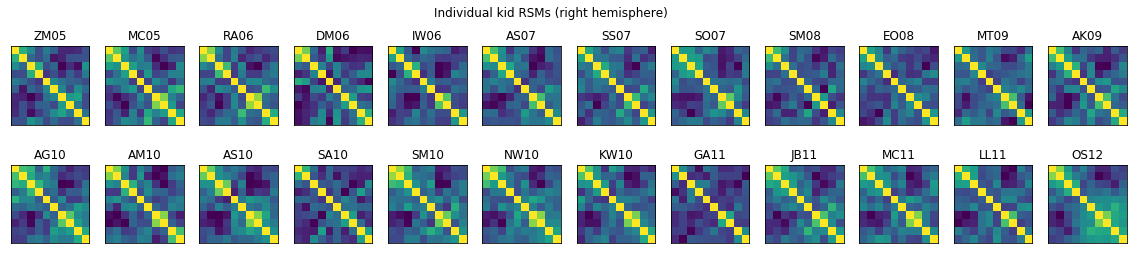

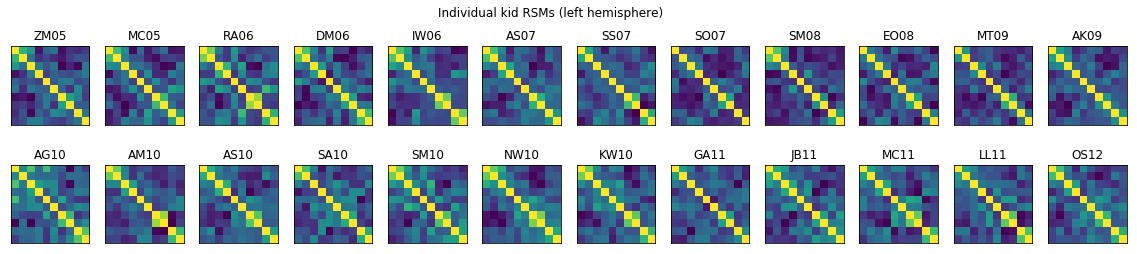

In [39]:
#let's look at these for the kids individually (sorted by age) to see if there's a more fine-grained picture

kids_age_sort = ('ZM05','MC05','RA06', 'DM06','IW06','AS07',
                'SS07', 'SO07', 'SM08', 'EO08', 'MT09',
                'AK09', 'AG10', 'AM10', 'AS10', 'SA10',
                'SM10', 'NW10', 'KW10', 'GA11',  'JB11',
                'MC11', 'LL11', 'OS12')

#right hemisphere
plt.figure(figsize=(20, 4))
plt.suptitle('Individual kid RSMs (right hemisphere)')

i = 1
for subj in kids_age_sort:
    subj_data = np.mean((run1_rh[subj], run2_rh[subj], run3_rh[subj]),axis=0)
    
    subj_corr = np.corrcoef(subj_data)
    
    plt.subplot(2, 12, i)
    plt.imshow(subj_corr)
    plt.xticks([]);plt.yticks(([]));
    plt.title(subj)
    
    i += 1

#left hemisphere
plt.figure(figsize=(20, 4))
plt.suptitle('Individual kid RSMs (left hemisphere)')

i = 1
for subj in kids_age_sort:
    subj_data = np.mean((run1_lh[subj], run2_lh[subj], run3_lh[subj]),axis=0)
    
    subj_corr = np.corrcoef(subj_data)
    
    plt.subplot(2, 12, i)
    plt.imshow(subj_corr)
    plt.xticks([]);plt.yticks(([]));
    plt.title(subj)
    
    i += 1

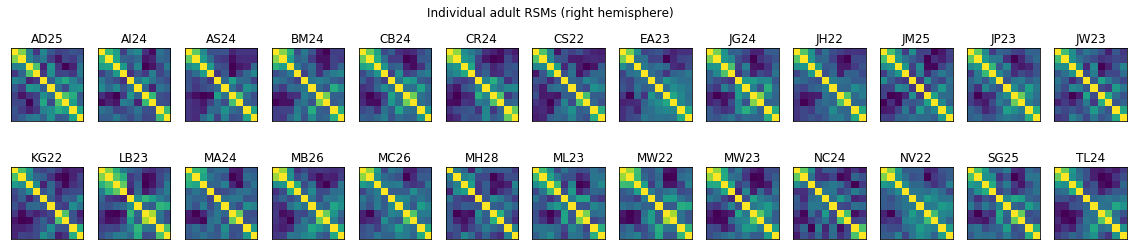

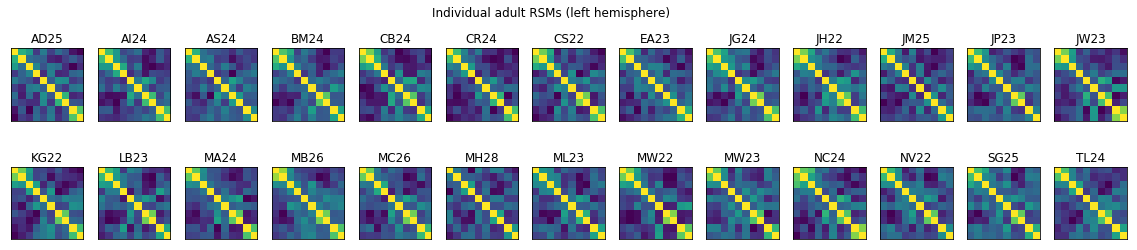

In [40]:
#adults for comparison

#right hemisphere
plt.figure(figsize=(20, 4))
plt.suptitle('Individual adult RSMs (right hemisphere)')

i = 1
for subj in adults:
    subj_data = np.mean((run1_rh[subj], run2_rh[subj], run3_rh[subj]),axis=0)
    
    subj_corr = np.corrcoef(subj_data)
    
    plt.subplot(2, 13, i)
    plt.imshow(subj_corr)
    #plt.yticks(np.arange(0, 10, 1), labels); 
    plt.xticks([]);plt.yticks(([]));
    
    i += 1

    plt.title(subj)
    
#left hemisphere
plt.figure(figsize=(20, 4))
plt.suptitle('Individual adult RSMs (left hemisphere)')

i = 1
for subj in adults:
    subj_data = np.mean((run1_lh[subj], run2_lh[subj], run3_lh[subj]),axis=0)
    
    subj_corr = np.corrcoef(subj_data)
    
    plt.subplot(2, 13, i)
    plt.imshow(subj_corr)
    #plt.yticks(np.arange(0, 10, 1), labels); 
    plt.xticks([]);plt.yticks(([]));
    
    i += 1

    plt.title(subj)

### Dimensionality reduction

Here, I wanted to see if these representations matrices could be reduced to a few principle components that tracked development, with the hope that this might tell us more about what exactly is changing and that in a future project, I could map a simple function to representation structure in VTC across development. 

In [41]:
from sklearn.decomposition import PCA as sklearn_PCA

Text(0.5,1,'Individual data points plotted in PC1/PC2 space')

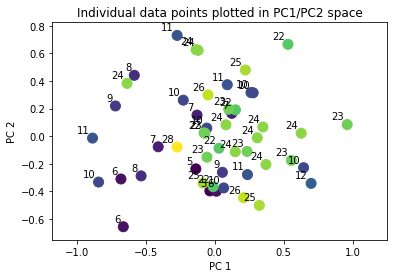

In [42]:
#let's run PCA
#now working in RDM space (I find the visualization easier to interpret)

#starting with the right hemisphere

#all age sort
all_age_sort = ('ZM05','MC05','RA06', 'DM06','IW06','AS07',
                'SS07', 'SO07', 'SM08', 'EO08', 'MT09',
                'AK09', 'AG10', 'AM10', 'AS10', 'SA10',
                'SM10', 'NW10', 'KW10', 'GA11',  'JB11',
                'MC11', 'LL11', 'OS12','KG22','MW22','NV22',
                'JH22','CS22', 'EA23','JP23', 'JW23','LB23',
                'ML23', 'MW23','AI24', 'AS24', 'BM24', 'CB24', 'CR24', 
                'JG24', 'MA24','NC24','TL24','AD25', 'JM25','SG25',
                'MB26', 'MC26', 'MH28')
all_flat_RDMs_rh = []
i = 1
for subj in all_age_sort:
    subj_data = np.mean((run1_rh[subj], run2_rh[subj], run3_rh[subj]),axis=0)
    
    subj_corr = 1-np.corrcoef(subj_data)
    
    lower_tril = np.tril(subj_corr, k=-1)
    lower_tril_flat = np.ravel(lower_tril[lower_tril!=0])
    all_flat_RDMs_rh.append(lower_tril_flat)

ages = [5,5,6,6,6,7,7,7,8,8,9,9,10,10,10,10,10,10,10,11,11,11,11,12,
   22,22,22,22,22,23,23,23,23,23,23,24,24,24,24,24,24,24,24,24,25,25,25,26,26,28]

cls = sklearn_PCA(n_components=5)
cls.fit(all_flat_RDMs_rh)

Xproj_rh = cls.transform(all_flat_RDMs_rh)

x_rh = Xproj_rh[:, 0]
y_rh = Xproj_rh[:, 1]

color = [str(item/255.) for item in ages]

plt.scatter(x_rh, y_rh, s=100, c=color)

plt.axis('equal')
plt.xlabel('PC 1')
plt.ylabel('PC 2')

for label, lx, ly in zip(ages, x_rh, y_rh):
    plt.annotate(
        label,
        xy=(lx, ly), xytext=(-3, 3),
        textcoords='offset points', ha='right', va='bottom')
    
plt.title('Individual data points plotted in PC1/PC2 space')
#this appears to separate out by age quite well

Text(0,0.5,'Ages')

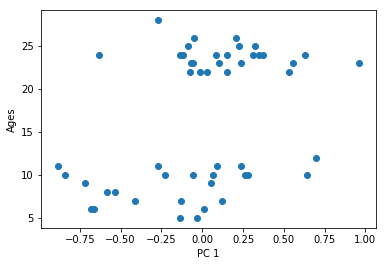

In [43]:
plt.scatter(x_rh,ages)
plt.xlabel('PC 1')
plt.ylabel('Ages')

#okay they don't totally separate out but it's not awful

In [44]:
#let's quantify this by looking at the correlation
stats.pearsonr(x_rh, ages)

(0.38050171183256976, 0.006413280907046776)

We see that there is a significant correlation between the first principal component and age (*r* = 0.38, *p* = .006)

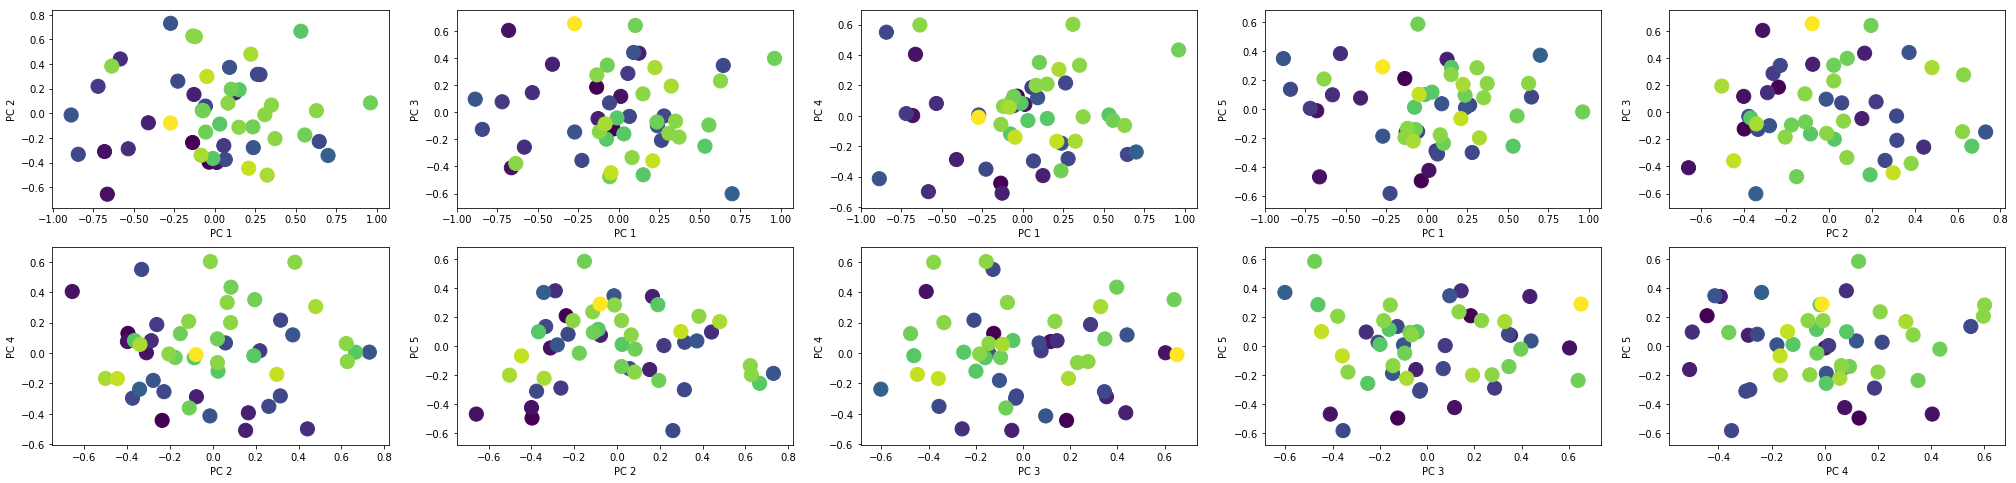

In [45]:
#would other components (within the top 5) separate it out better?
plt.figure(figsize=(35,8))

x = Xproj_rh[:, 0]; y = Xproj_rh[:, 1];
plt.subplot(2,5,1)
plt.scatter(x, y, s=200, c=color)
plt.xlabel('PC 1'); plt.ylabel('PC 2');

x = Xproj_rh[:, 0]; y = Xproj_rh[:, 2];
plt.subplot(2,5,2)
plt.scatter(x, y, s=200, c=color)
plt.xlabel('PC 1'); plt.ylabel('PC 3');

x = Xproj_rh[:, 0]; y = Xproj_rh[:, 3];
plt.subplot(2,5,3)
plt.scatter(x, y, s=200, c=color)
plt.xlabel('PC 1'); plt.ylabel('PC 4');

x = Xproj_rh[:, 0]; y = Xproj_rh[:, 4];
plt.subplot(2,5,4)
plt.scatter(x, y, s=200, c=color)
plt.xlabel('PC 1'); plt.ylabel('PC 5');

x = Xproj_rh[:, 1]; y = Xproj_rh[:, 2];
plt.subplot(2,5,5)
plt.scatter(x, y, s=200, c=color)
plt.xlabel('PC 2'); plt.ylabel('PC 3');

x = Xproj_rh[:, 1]; y = Xproj_rh[:, 3];
plt.subplot(2,5,6)
plt.scatter(x, y, s=200, c=color)
plt.xlabel('PC 2'); plt.ylabel('PC 4');

x = Xproj_rh[:, 1]; y = Xproj_rh[:, 4];
plt.subplot(2,5,7)
plt.scatter(x, y, s=200, c=color)
plt.xlabel('PC 2'); plt.ylabel('PC 5');

x = Xproj_rh[:, 2]; y = Xproj_rh[:, 3];
plt.subplot(2,5,8)
plt.scatter(x, y, s=200, c=color)
plt.xlabel('PC 3'); plt.ylabel('PC 4');

x = Xproj_rh[:, 2]; y = Xproj_rh[:, 4];
plt.subplot(2,5,9)
plt.scatter(x, y, s=200, c=color)
plt.xlabel('PC 3'); plt.ylabel('PC 5');

x = Xproj_rh[:, 3]; y = Xproj_rh[:, 4];
plt.subplot(2,5,10)
plt.scatter(x, y, s=200, c=color)
plt.xlabel('PC 4'); plt.ylabel('PC 5');

#not really
#looks like PC1 probably tracks age the best

Text(0.5,1,'Cumulative "Scree" plot')

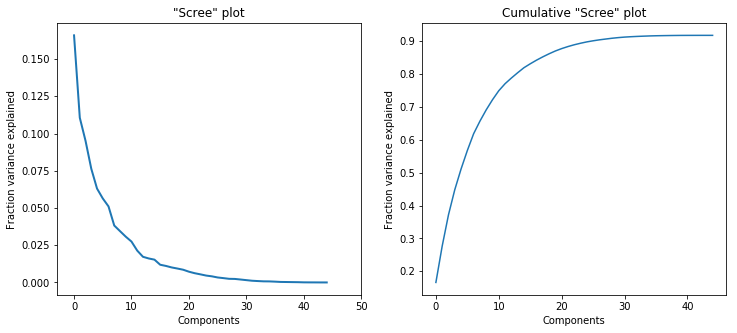

In [46]:
#how much of the variance are we capturing with that PC though?
cls = sklearn_PCA()
cls.fit(all_flat_RDMs_rh)

plt.figure(figsize = (12, 5))
plt.subplot(121)
plt.plot(cls.explained_variance_, linewidth=2)
plt.xlim(-3, 50)
plt.ylabel('Fraction variance explained')
plt.xlabel('Components')
plt.title('"Scree" plot')
plt.subplot(122)
plt.plot(cls.explained_variance_.cumsum())
plt.ylabel('Fraction variance explained')
plt.xlabel('Components')
plt.title('Cumulative "Scree" plot')

#okay, not all of it but it's not awful

Text(0.5,0,'PC 3')

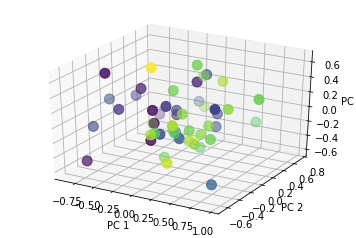

In [47]:
#maybe 3 components would be better? let's try a 3D visualization

from mpl_toolkits.mplot3d import Axes3D

x = Xproj_rh[:, 0]
y = Xproj_rh[:, 1]
z = Xproj_rh[:, 2]

color = [str(item/255.) for item in ages]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x, y, z, s=100, c=color)

ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')

#hmm this isn't really clearer

In [48]:
#okay what does it look like if we sample evenly from this PC1 space?
#(i.e. what is that principle component really tracking)

X = np.empty([10,2])

cls = sklearn_PCA(n_components=2)
cls.fit(all_flat_RDMs_rh)

sim_data = np.linspace(-1.0, 1.0, num=10)
X[:,0] = sim_data
X[:,1] = np.linspace(0, 0, num=10) #zeros

sim_RDMs_rh = cls.inverse_transform(X) #weeee RDMs

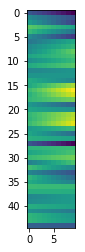

In [49]:
plt.imshow(sim_RDMs_rh.T)

In [50]:
#reconstruct the RDMs to be 10x10 symmetric matrices
#(testing with the first and last matrices in our sample space)
il1 = np.tril_indices(10,-1)
recon_min = np.zeros([10,10])
recon_min[il1[0],il1[1]] = sim_RDMs_rh[0]
recon_sym_min = recon_min + recon_min.T

recon_max = np.zeros([10,10])
recon_max[il1[0],il1[1]] = sim_RDMs_rh[9]
recon_sym_max = recon_max + recon_max.T

#get back into correlation space instead of distance space
recon_sym_min_corr = 1-recon_sym_min
recon_sym_max_corr = 1-recon_sym_max

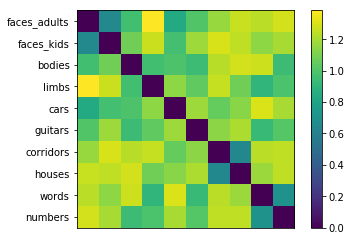

In [51]:
#furthest 'left' in PC1 space
plt.imshow(recon_sym_min)
plt.colorbar()
plt.yticks(np.arange(0, 10, 1), labels); plt.xticks([]);

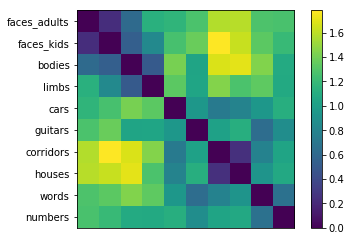

In [52]:
#furthest 'right' in PC1 space
plt.imshow(recon_sym_max)
plt.colorbar()
plt.yticks(np.arange(0, 10, 1), labels); plt.xticks([]);
# more domain structure?

In [53]:
#okay let's reconstruct all the RDMs to be 10x10 symmetric matrices
il1 = np.tril_indices(10,-1)

recon = np.zeros([len(sim_RDMs_rh),10,10])
recon_sym = np.zeros([len(sim_RDMs_rh),10,10])

for ind in range(len(sim_RDMs_rh)):
    recon[ind,il1[0],il1[1]] = sim_RDMs_rh[ind]
    recon_sym[ind] = recon[ind] + recon[ind].T

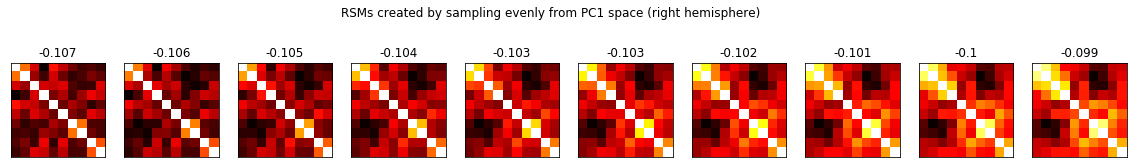

In [54]:
plt.figure(figsize=(20, 3))
plt.suptitle('RSMs created by sampling evenly from PC1 space (right hemisphere)')

i = 1
for ind in range(len(sim_RDMs_rh)):
      
    plt.subplot(1, 10, i)
    plt.imshow(1-recon_sym[ind], 'hot')
    plt.title(round(np.mean(1-sim_RDMs_rh[ind]),3))
    #plt.colorbar()
    #plt.yticks(np.arange(0, 10, 1), labels); plt.xticks([]);
    plt.xticks([]);plt.yticks(([]));
    
    i += 1

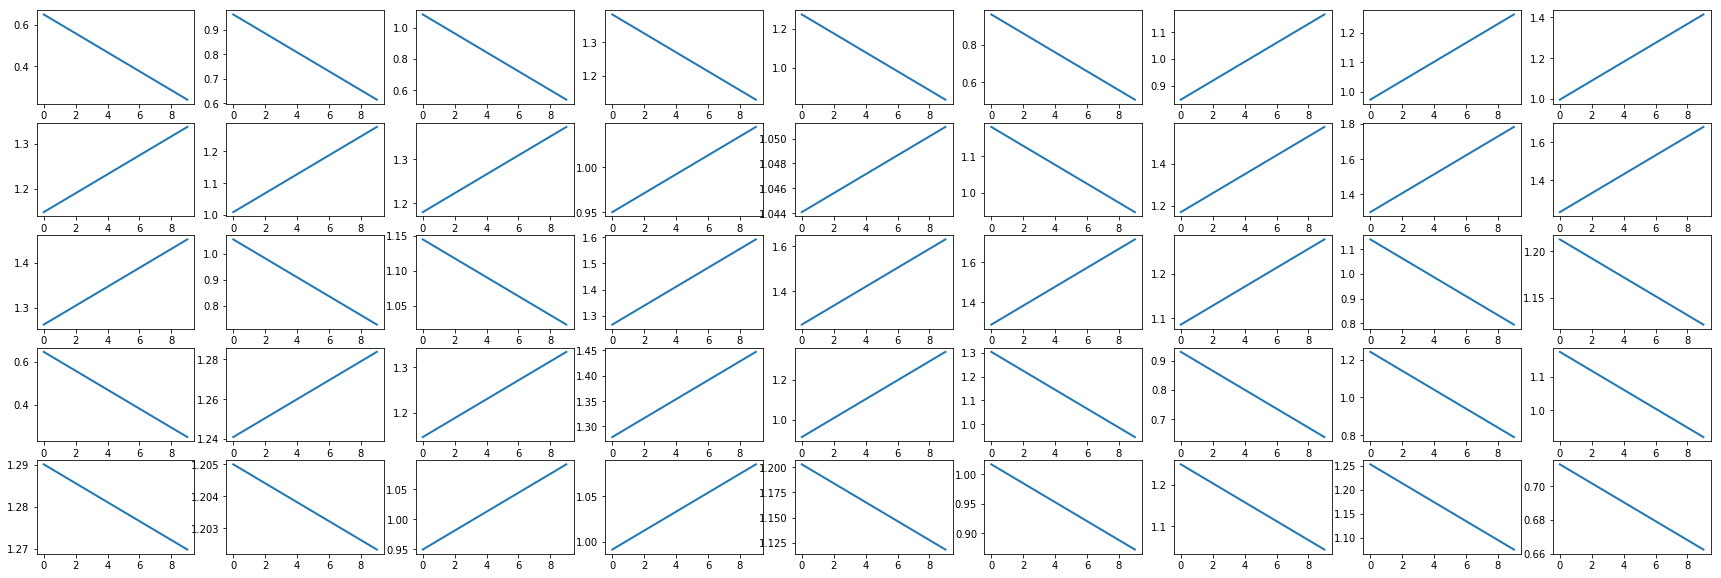

In [55]:
#uh oh are all the correlation values just increasing? (i.e. dist values decreasing)
plt.figure(figsize = (30, 10))
for corr in range(len(sim_RDMs_rh[0])):
    plt.subplot(5,9,corr+1)
    plt.plot(sim_RDMs_rh[:,corr], linewidth=2)

#no but they all linearly increase or decrease 
#hmmm - is this to be expected?

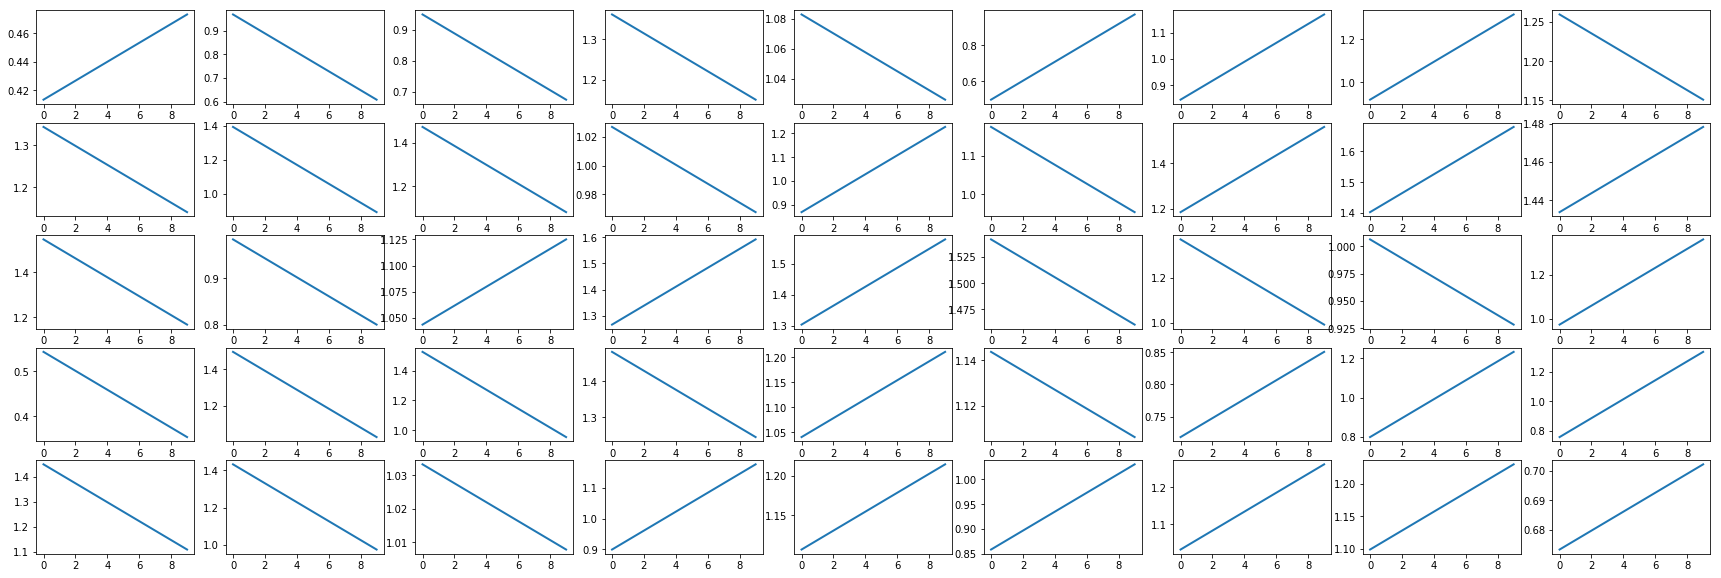

In [56]:
#what if I do this for PC2?
X2 = np.empty([10,2])

X2[:,0] = np.linspace(0, 0, num=10) #zeros
X2[:,1] = sim_data

PC2_sim_RDMs = cls.inverse_transform(X2) 

plt.figure(figsize = (30, 10))
for corr in range(len(PC2_sim_RDMs[0])):
    plt.subplot(5,9,corr+1)
    plt.plot(PC2_sim_RDMs[:,corr], linewidth=2)

#phew

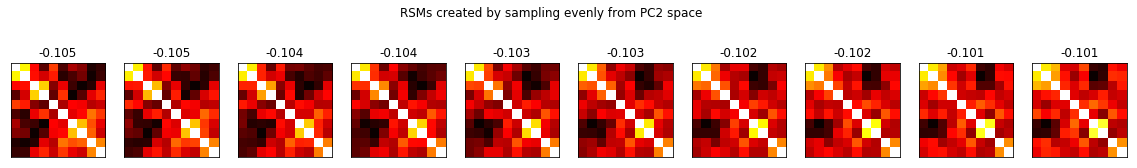

In [57]:
#out of curiosity what do these RSMs look like?
PC2_recon = np.zeros([len(PC2_sim_RDMs),10,10])
PC2_recon_sym = np.zeros([len(PC2_sim_RDMs),10,10])

for ind in range(len(PC2_sim_RDMs)):
    PC2_recon[ind,il1[0],il1[1]] = PC2_sim_RDMs[ind]
    PC2_recon_sym[ind] = PC2_recon[ind] + PC2_recon[ind].T

plt.figure(figsize=(20, 3))
plt.suptitle('RSMs created by sampling evenly from PC2 space')

i = 1
for ind in range(len(PC2_sim_RDMs)):
      
    plt.subplot(1, 10, i)
    plt.imshow(1-PC2_recon_sym[ind], 'hot')
    plt.title(round(np.mean(1-PC2_sim_RDMs[ind]),3))
    #plt.colorbar()
    #plt.yticks(np.arange(0, 10, 1), labels); plt.xticks([]);
    plt.xticks([]);plt.yticks(([]));
    
    i += 1

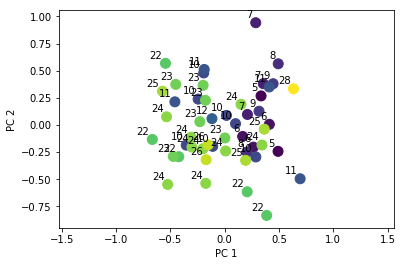

In [58]:
## Let's do some of thia again but for the left hemisphere
all_flat_RDMs_lh = []
i = 1
for subj in all_age_sort:
    subj_data = np.mean((run1_lh[subj], run2_lh[subj], run3_lh[subj]),axis=0)
    
    subj_corr = 1-np.corrcoef(subj_data)
    
    lower_tril = np.tril(subj_corr, k=-1)
    lower_tril_flat = np.ravel(lower_tril[lower_tril!=0])
    all_flat_RDMs_lh.append(lower_tril_flat)

cls = sklearn_PCA(n_components=5)
cls.fit(all_flat_RDMs_lh)

Xproj_lh = cls.transform(all_flat_RDMs_lh)

x_lh = Xproj_lh[:, 0]
y_lh = Xproj_lh[:, 1]

color = [str(item/255.) for item in ages]

plt.scatter(x_lh, y_lh, s=100, c=color)

plt.axis('equal')
plt.xlabel('PC 1')
plt.ylabel('PC 2')

for label, lx, ly in zip(ages, x_lh, y_lh):
    plt.annotate(
        label,
        xy=(lx, ly), xytext=(-3, 3),
        textcoords='offset points', ha='right', va='bottom')


Text(0,0.5,'Ages')

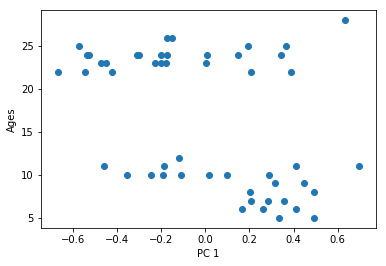

In [59]:
plt.scatter(x_lh,ages)
plt.xlabel('PC 1')
plt.ylabel('Ages')


In [63]:
#let's quantify this by looking at the correlation
stats.pearsonr(x_lh, ages)

(-0.4372456466252637, 0.0014979380597150665)

We see that there is a significant correlation between the first principal component and age (*r* = -0.44, *p* = .001)

In [60]:
#what does it look like if we sample evenly from PCA space?

X = np.empty([10,2])

cls = sklearn_PCA(n_components=2)
cls.fit(all_flat_RDMs_lh)

sim_data = np.linspace(-1.0, 1.0, num=10)
X[:,0] = sim_data
X[:,1] = np.linspace(0, 0, num=10) #zeros

sim_RDMs_lh = cls.inverse_transform(X) #weeee RDMs

In [61]:
#okay let's reconstruct all the RDMs to be 10x10 symmetric matrices
il1 = np.tril_indices(10,-1)

recon = np.zeros([len(sim_RDMs_lh),10,10])
recon_sym = np.zeros([len(sim_RDMs_lh),10,10])

for ind in range(len(sim_RDMs_lh)):
    recon[ind,il1[0],il1[1]] = sim_RDMs_lh[ind]
    recon_sym[ind] = recon[ind] + recon[ind].T


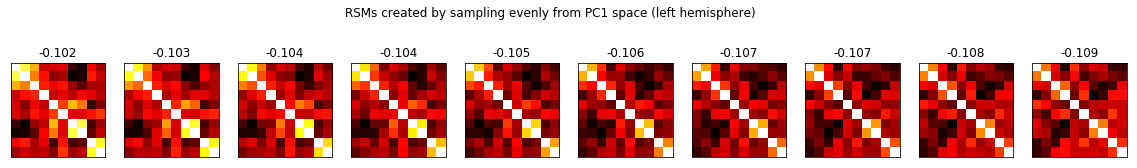

In [62]:
plt.figure(figsize=(20, 3))
plt.suptitle('RSMs created by sampling evenly from PC1 space (left hemisphere)')

i = 1
for ind in range(len(sim_RDMs_lh)):
      
    plt.subplot(1, 10, i)
    plt.imshow(1-recon_sym[ind], 'hot')
    plt.title(round(np.mean(1-sim_RDMs_lh[ind]),3))
    #plt.colorbar()
    #plt.yticks(np.arange(0, 10, 1), labels); plt.xticks([]);
    plt.xticks([]);plt.yticks(([]));
    
    i += 1
    
#left most RSMs most frequently correspond with the adult subjects and right most RSMs correspond most with younger subjects
#again the first PC (i.e. the PC that explains the most variance) appears to track domain formation 
#and this corresponds well with age

## Conclusions

In this project, I looked to explore the development of object and category representations in human VTC using the methods we learnt about in this class, namely classification, representational similarity analysis and dimensionality reduction. Testing three types of classifiers (a minimum distance correlation classifier, a linear support vector classifier, and a k-nearest neighbors classifier), I found that both the minimum distance classifier and the support vector classifier performed well, with the linear support vector classifier slightly edging out the distance classifier. Using the linear support vector classifier, I found that object categories could be well classified from the z-scored beta values of VTC voxels in both hemispheres and both age cohorts (chance level = 10%; adult average classification accuracy: left hemisphere = 54.10%, right hemisphere = 48.72%; kids average classification accuracy: left hemisphere = 50.56%, right hemisphere = 47.22%), with no significant difference in accuracy between the two cohorts. However, I did find a significant difference in the within domain (i.e. the superordinate category) classification accuracy between the two age groups with classification accuracy significantly higher for adults than kids in both the right (adult mean accuracy = 83.85%, kids mean accuracy = 76.25%, *t*(48) = 3.51, *p* < .001) and left (adult mean accuracy = 84.23%, kids mean accuracy = 75.97%, *t*(48) = 3.52, *p* < .001) hemispheres. This suggests that while individual object representations in VTC may be well-formed early on (by age 5), domain representations are still sharpening throughout childhood.

To get at this further, I decided to run dimensionality reduction on the representational similarity matrices to see what the components were that explained the most variance in the data. I found that the first principal component in both the right and left hemispheres appears to track the formation of domains (based on visualization of the PC space). Additionally, this component was significantly correlated with age in both hemispheres (right hemisphere: *r* = 0.38, *p* = .006; left hemisphere: *r* = -0.44, *p* = .001). While largely exploratory, this project suggests that while specific object catgeories may be well-formed in VTC from age 5, child and adult object representations in VTC are distinct in that there are clearer domain boundaries in adult VTC. In future work, I hope to pursue this further and more fully map the trajectory of the representations across development, with a potential end goal being comparing this trajectory to the trajectory of a neural network. 

## References

Feinberg, D.A., Setsompop, K., 2013. Ultra-fast MRI of the human brain with simultaneous multi-slice imaging. J. Magn. Reson. 229, 90–100. https://doi.org/10.1016/J.JMR.2013.02.002

Stigliani, A., Weiner, K.S., Grill-Spector, K., 2015. Temporal Processing Capacity in High-Level Visual Cortex Is Domain Specific. J. Neurosci. 35, 12412–12424. https://doi.org/10.1523/JNEUROSCI.4822-14.2015

Weiner, K.S., Grill-Spector, K., 2010. Sparsely-distributed organization of face and limb activations in human ventral temporal cortex. https://doi.org/10.1016/j.neuroimage.2010.04.262